# Sensitivity Analysis and Design of Experiment 

In this document; we want to do some data cleaning and sensitivity analysis on the result of single-phase non-Newtonian fluid flow through 2 dimentional Berea sandeston with 400 * 400 lattices


## importing essential libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/SA-2D/Berea/

/content/drive/MyDrive/SA-2D/Berea


In [ ]:
ls

Berea02.csv  Berea2D.ipynb  Berea.gsheet  Berea.xlsx  res-164.zip
Berea03.csv  Berea.csv      BereaP.csv    cu1.zip


In [ ]:
Berea= pd.read_csv('BereaResult.csv')

In [ ]:
Berea.columns

Index(['deltaP', 'Umax', 'Re', 'Cu', 'n', 'Nu0', 'NuInf', 'Lambda', 'AvgOmega',
       'AvgNu', 'AvgVel', 'AvgP', 'PG', 'q', 'AvgVelOut'],
      dtype='object')

In [ ]:
Berea['deltaP'].unique()

array([1.e-05, 5.e-05, 1.e-04, 5.e-04, 1.e-03, 5.e-03, 1.e-02])

## Feature engineering

plotting every variable with respect to other to see the possible correlations

Figure below indicates the visualization of correlation of each variable with respect to others

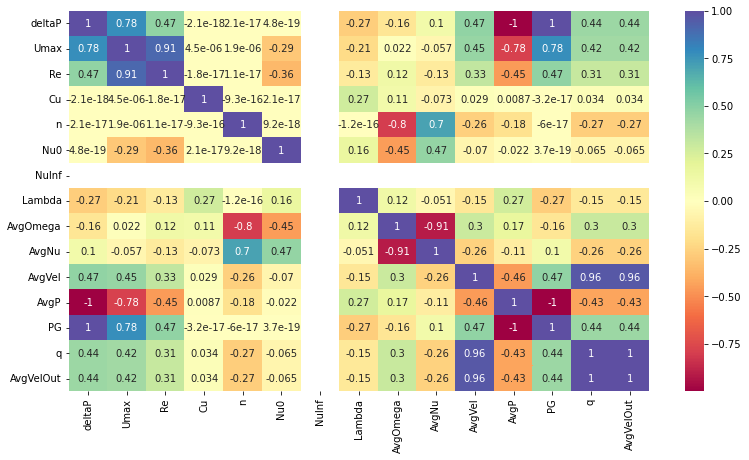

In [ ]:
plt.figure(figsize=(13,7))
sns.heatmap(Berea.corr(),cmap="Spectral",annot=True)

the above results indicates that since we are working with incompressible flow; pressure will not change through simulation.
So; pressure difference in the begginig of simulation is highly correlated with average pressure at the end of run time and we can get rid of one of them.
NuInf was considered zero for all simulation cases so we decided to omitt that.
Also, we decided to omitt highly correlated columns.

In [ ]:
Berea.drop(['AvgP','PG','NuInf','AvgVelOut','AvgOmega'],axis=1,inplace=True)

plt.figure(figsize=(13,7))
sns.heatmap(Berea.corr(),cmap="Spectral",annot=True)

Also, in order to analyze data more easily, I created a categorical column for maximum velocity and Reynolds number

In [ ]:
Berea['categorical_Re']=pd.cut(Berea['Re'], bins=10)

In [ ]:
Berea['categorical_Umax']=pd.cut(Berea['Umax'], bins=10)

In [ ]:
Berea.head()

deltaP          Umax  ...     categorical_Re       categorical_Umax
0  0.00001  2.370000e-06  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
1  0.00001  1.230000e-06  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
2  0.00001  8.650000e-07  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
3  0.00001  6.920000e-07  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
4  0.00001  5.930000e-07  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]

[5 rows x 12 columns]

In [ ]:
Berea

deltaP          Umax  ...     categorical_Re       categorical_Umax
0     0.00001  2.370000e-06  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
1     0.00001  1.230000e-06  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
2     0.00001  8.650000e-07  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
3     0.00001  6.920000e-07  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
4     0.00001  5.930000e-07  ...  (-0.00949, 0.972]  (-1.97e-06, 0.000243]
...       ...           ...  ...                ...                    ...
2235  0.01000  7.090380e-04  ...  (-0.00949, 0.972]   (0.000486, 0.000729]
2236  0.01000  6.070070e-04  ...  (-0.00949, 0.972]   (0.000486, 0.000729]
2237  0.01000  5.399380e-04  ...  (-0.00949, 0.972]   (0.000486, 0.000729]
2238  0.01000  4.958960e-04  ...  (-0.00949, 0.972]   (0.000486, 0.000729]
2239  0.01000  4.632600e-04  ...  (-0.00949, 0.972]   (0.000243, 0.000486]

[2240 rows x 12 columns]

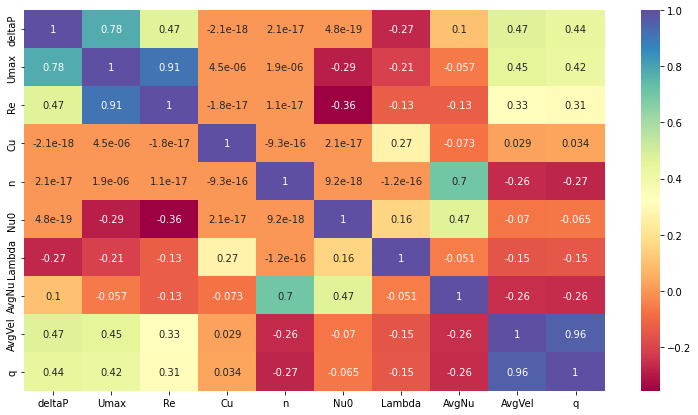

In [ ]:
plt.figure(figsize=(13,7))
sns.heatmap(Berea.corr(),cmap="Spectral",annot=True)

In [ ]:
Berea.corr().abs()['AvgNu'].sort_values(ascending=False)

AvgNu     1.000000
n         0.704414
Nu0       0.467943
q         0.256581
AvgVel    0.256007
Re        0.127203
deltaP    0.102767
Cu        0.073005
Umax      0.057066
Lambda    0.051269
Name: AvgNu, dtype: float64

It could be understood from the above figure that the average viscosity at the end of simulation is correlated with power-law exponent, Nu0, then average velocity,etc. We will talk about it later in this report.

## Data cleaning

But first; lets do some data cleaning and investigate which values for each input parameters were more responsible for divergance

In [ ]:
100*Berea.isnull().sum()/len(Berea)

deltaP               0.000000
Umax                 0.000000
Re                   0.000000
Cu                   0.000000
n                    0.000000
Nu0                  0.000000
Lambda               0.000000
AvgNu               24.330357
AvgVel              24.330357
q                   24.330357
categorical_Re       0.000000
categorical_Umax     0.000000
dtype: float64

Since in the input we have no null argument and the count of null value in each of the result parameters are identical; we select "AvgNu as a representative of results and we will countinue data cleaning with this parameter 

In [ ]:
class Berea_nullcounts:
    """
    this class calculates fraction of null numbers per category (delta P and n)
    """
    def __init__(self, df):
        self.df =df           
        self.totalcount_n=(df.groupby([df["n"]]).count().astype(int)+df.isnull().groupby([df["n"]]).sum().astype(int))['AvgNu']
        self.totalcount_p=(df.groupby([df["deltaP"]]).count().astype(int)+df.isnull().groupby([df["deltaP"]]).sum().astype(int))['AvgNu']
        self.totalcount_nu0=(df.groupby([df["Nu0"]]).count().astype(int)+df.isnull().groupby([df["Nu0"]]).sum().astype(int))['AvgNu']
        self.totalcount_Cu=(df.groupby([df["Cu"]]).count().astype(int)+df.isnull().groupby([df["Cu"]]).sum().astype(int))['AvgNu']
        self.totalcount_categorical_Umax=(df.groupby([df["categorical_Umax"]]).count().astype(int)+df.isnull().groupby([df["categorical_Umax"]]).sum().astype(int))['AvgNu']
        self.totalcount_categorical_Re=(df.groupby([df["categorical_Re"]]).count().astype(int)+df.isnull().groupby([df["categorical_Re"]]).sum().astype(int))['AvgNu']
        
        self.Nullcount_n=df.isnull().groupby([df["n"]]).sum().astype(int)['AvgNu']
        self.Nullcount_p=df.isnull().groupby([df["deltaP"]]).sum().astype(int)['AvgNu']
        self.Nullcount_nu0=df.isnull().groupby([df["Nu0"]]).sum().astype(int)['AvgNu']
        self.Nullcount_Cu=df.isnull().groupby([df["Cu"]]).sum().astype(int)['AvgNu']
        self.Nullcount_categorical_Umax=df.isnull().groupby([df["categorical_Umax"]]).sum().astype(int)['AvgNu']
        self.Nullcount_categorical_Re=df.isnull().groupby([df["categorical_Re"]]).sum().astype(int)['AvgNu']
        
        self.fracNull_p=self.Nullcount_p/self.totalcount_p
        self.fracNull_n=self.Nullcount_n/self.totalcount_n
        self.fracNull_nu0=self.Nullcount_nu0/self.totalcount_nu0
        self.fracNull_Cu=self.Nullcount_Cu/self.totalcount_Cu
        self.fracNull_categorical_Umax=self.Nullcount_categorical_Umax/self.totalcount_categorical_Umax
        self.fracNull_categorical_Re=self.Nullcount_categorical_Re/self.totalcount_categorical_Re

In [ ]:
first=Berea_nullcounts(Berea)

In [ ]:
first.fracNull_nu0

Nu0
0.1    0.310714
0.2    0.278571
0.3    0.260714
0.4    0.242857
0.5    0.228571
0.6    0.217857
0.7    0.207143
0.8    0.200000
Name: AvgNu, dtype: float64

In [ ]:
first.fracNull_p 

deltaP
0.00001    0.000000
0.00005    0.165625
0.00010    0.212500
0.00050    0.275000
0.00100    0.309375
0.00500    0.359375
0.01000    0.381250
Name: AvgNu, dtype: float64

In [ ]:
first.fracNull_n

n
0.3    0.828571
0.4    0.703571
0.5    0.357143
0.6    0.057143
0.7    0.000000
0.8    0.000000
0.9    0.000000
1.0    0.000000
Name: AvgNu, dtype: float64

In [ ]:
first.fracNull_Cu

Cu
1     0.145089
5     0.229911
10    0.265625
15    0.281250
20    0.294643
Name: AvgNu, dtype: float64

In [ ]:
first.fracNull_categorical_Umax

categorical_Umax
(-1.97e-06, 0.000243]    0.195122
(0.000243, 0.000486]     0.337500
(0.000486, 0.000729]     0.360000
(0.000729, 0.000972]     0.400000
(0.000972, 0.00122]      0.475000
(0.00122, 0.00146]       0.450000
(0.00146, 0.0017]             NaN
(0.0017, 0.00194]             NaN
(0.00194, 0.00219]            NaN
(0.00219, 0.00243]       0.475000
Name: AvgNu, dtype: float64

In [ ]:
first.fracNull_categorical_Re

categorical_Re
(-0.00949, 0.972]    0.22402
(0.972, 1.943]       0.40000
(1.943, 2.915]       0.45000
(2.915, 3.886]           NaN
(3.886, 4.858]       0.47500
(4.858, 5.829]           NaN
(5.829, 6.801]           NaN
(6.801, 7.772]           NaN
(7.772, 8.744]           NaN
(8.744, 9.715]       0.47500
Name: AvgNu, dtype: float64

It seems that rows with highest pressure difference, lowest power-law exponent, highest Reynolds  number and average velocity, highest Curreau number and highest Nu_0 are good candidates for deletion.
Without going any further,first let's explore it a little bit more

In [ ]:
class nullcounts_n_deltaP_Nu0_Cu:
    """
    This class 
    
    """
    def __init__(self, df):
        self.df =df

        self.N=df['n'].unique()
        self.deltaP=df['deltaP'].unique()
        self.Nu0=df['Nu0'].unique()
        self.Cu=df['Cu'].unique()
        
        self.n_key=list(map(lambda i:str(i),self.N))
        self.deltaP_key=list(map(lambda i:str(i),self.deltaP))
        self.Nu0_key=list(map(lambda i:str(i),self.Nu0))
        self.Cu_key=list(map(lambda i:str(i),self.Cu))

        ##for n and delta P
        j=0
        while j<len(self.N):
            
            self.null_n = df[df["n"]==self.N[j]].isnull().groupby([df["deltaP"]]).sum().astype(int)["AvgNu"]
            self.total_n=(df[df["n"]==self.N[j]].groupby([df["deltaP"]]).count().astype(int)+df[df["n"]==self.N[j]].isnull().groupby([df["deltaP"]]).sum().astype(int))["AvgNu"]
            self.fullfrac_n=self.null_n/self.total_n
            
            if j>0:

                #self.result=pd.concat([self.result,self.d],,axis=1)
                self.result_n_p=pd.concat([self.fullfrac_n,self.result_n_p],axis=1)
            else:
                self.result_n_p=self.fullfrac_n               
            j=j+1  
            
        self.result_n_p.columns=self.n_key
        
        ##for Nu0 and n
        j=0
        while j<len(self.Nu0):
            
            self.null_Nu0 = df[df["Nu0"]==self.Nu0[j]].isnull().groupby([df["n"]]).sum().astype(int)["AvgNu"]
            self.total_Nu0=(df[df["Nu0"]==self.Nu0[j]].groupby([df["n"]]).count().astype(int)+df[df["Nu0"]==self.Nu0[j]].isnull().groupby([df["n"]]).sum().astype(int))["AvgNu"]
            self.fullfrac_Nu0=self.null_Nu0/self.total_Nu0
            
            if j>0:

                #self.result=pd.concat([self.result,self.d],,axis=1)
                self.result_Nu0_n=pd.concat([self.result_Nu0_n,self.fullfrac_Nu0],axis=1)
            else:
                self.result_Nu0_n=self.fullfrac_Nu0              
            j=j+1  
            
        self.result_Nu0_n.columns=self.Nu0_key
        
        
        ##for Nu0 and deltaP
        j=0
        while j<len(self.deltaP):
            
            self.null_deltaP= df[df["deltaP"]==self.deltaP[j]].isnull().groupby([df["Nu0"]]).sum().astype(int)["AvgNu"]
            self.total_deltaP=(df[df["deltaP"]==self.deltaP[j]].groupby([df["Nu0"]]).count().astype(int)+df[df["deltaP"]==self.deltaP[j]].isnull().groupby([df["Nu0"]]).sum().astype(int))["AvgNu"]
            self.fullfrac_deltaP=self.null_deltaP/self.total_deltaP
            
            if j>0:

                #self.result=pd.concat([self.result,self.d],,axis=1)
                self.result_deltaP_Nu0=pd.concat([self.result_deltaP_Nu0,self.fullfrac_deltaP],axis=1)
            else:
                self.result_deltaP_Nu0=self.fullfrac_deltaP            
            j=j+1  
            
        self.result_deltaP_Nu0.columns=self.deltaP_key
        
        ##for n and Cu
        j=0
        while j<len(self.N):
            
            self.null_n = df[df["n"]==self.N[j]].isnull().groupby([df["Cu"]]).sum().astype(int)["AvgNu"]
            self.total_n=(df[df["n"]==self.N[j]].groupby([df["Cu"]]).count().astype(int)+df[df["n"]==self.N[j]].isnull().groupby([df["Cu"]]).sum().astype(int))["AvgNu"]
            self.fullfrac_n=self.null_n/self.total_n
            
            if j>0:

                #self.result=pd.concat([self.result,self.d],,axis=1)
                self.result_n_Cu=pd.concat([self.result_n_Cu,self.fullfrac_n],axis=1)
            else:
                self.result_n_Cu=self.fullfrac_n               
            j=j+1  
            
        self.result_n_Cu.columns=self.n_key
        
        ##for Nu0 and Cu
        j=0
        while j<len(self.Nu0):
            
            self.null_Nu0 = df[df["Nu0"]==self.Nu0[j]].isnull().groupby([df["Cu"]]).sum().astype(int)["AvgNu"]
            self.total_Nu0=(df[df["Nu0"]==self.Nu0[j]].groupby([df["Cu"]]).count().astype(int)+df[df["Nu0"]==self.Nu0[j]].isnull().groupby([df["Cu"]]).sum().astype(int))["AvgNu"]
            self.fullfrac_Nu0=self.null_Nu0/self.total_Nu0
            
            if j>0:

                #self.result=pd.concat([self.result,self.d],,axis=1)
                self.result_Nu0_Cu=pd.concat([self.result_Nu0_Cu,self.fullfrac_Nu0],axis=1)
            else:
                self.result_Nu0_Cu=self.fullfrac_Nu0              
            j=j+1  
            
        self.result_Nu0_Cu.columns=self.Nu0_key
        
        ##for deltaP and Cu
        j=0
        while j<len(self.deltaP):
            
            self.null_deltaP = df[df["deltaP"]==self.deltaP[j]].isnull().groupby([df["Cu"]]).sum().astype(int)["AvgNu"]
            self.total_deltaP=(df[df["deltaP"]==self.deltaP[j]].groupby([df["Cu"]]).count().astype(int)+df[df["deltaP"]==self.deltaP[j]].isnull().groupby([df["Cu"]]).sum().astype(int))["AvgNu"]
            self.fullfrac_deltaP=self.null_deltaP/self.total_deltaP
            
            if j>0:

                #self.result=pd.concat([self.result,self.d],,axis=1)
                self.result_deltaP_Cu=pd.concat([self.result_deltaP_Cu,self.fullfrac_deltaP],axis=1)
            else:
                self.result_deltaP_Cu=self.fullfrac_deltaP              
            j=j+1  
            
        self.result_deltaP_Cu.columns=self.deltaP_key
               
        #figures
        
        plt.figure(figsize=(8,5))       
        sns.heatmap(self.result_n_p,annot=True)
        plt.title("Null Fraction n vs. deltaP")

        plt.figure(figsize=(8,5))
        #self.result_Nu0_n.sort_index(level=0, ascending=False, inplace=True)
        sns.heatmap(self.result_Nu0_n,annot=True)
        plt.title("Null Fraction Nu0 vs. n")

        plt.figure(figsize=(8,5))
        #self.result_deltaP_Nu0.sort_index(level=0, ascending=False, inplace=True)
        sns.heatmap(self.result_deltaP_Nu0,annot=True)
        plt.title("Null Fraction deltaP vs. Nu0")

        plt.figure(figsize=(8,5))
        #self.result_n_Cu.sort_index(level=0, ascending=False, inplace=True)
        sns.heatmap(self.result_n_Cu,annot=True)
        plt.title("Null Fraction n vs. Cu")

        plt.figure(figsize=(8,5))
        #self.result_Nu0_Cu.sort_index(level=0, ascending=False, inplace=True)
        sns.heatmap(self.result_Nu0_Cu,annot=True)
        plt.title("Null Fraction Nu0 vs. Cu")

        plt.figure(figsize=(8,5))
        #self.result_deltaP_Cu.sort_index(level=0, ascending=False, inplace=True)
        sns.heatmap(self.result_deltaP_Cu,annot=True)
        plt.title("Null Fraction deltaP vs. Cu")
        
        


        

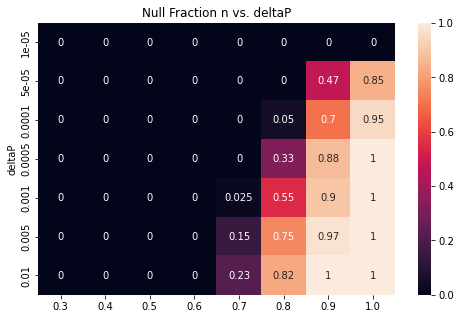

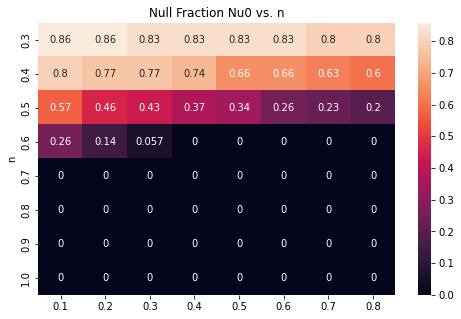

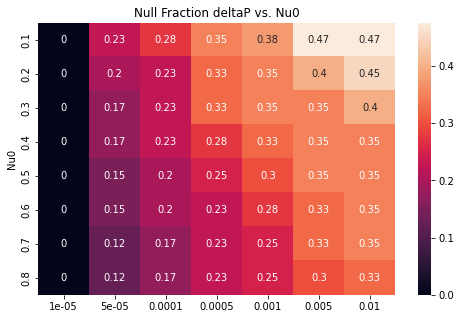

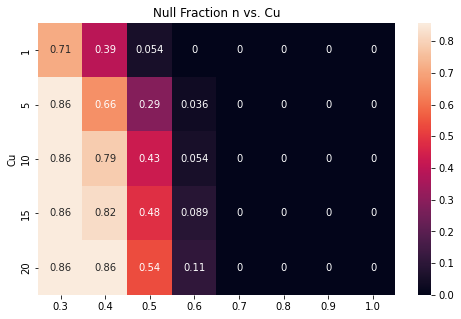

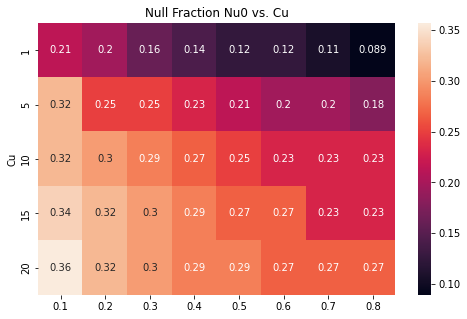

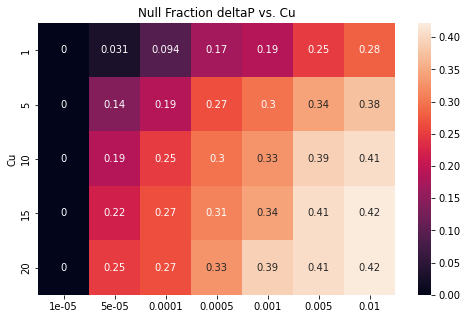

In [ ]:
first=nullcounts_n_deltaP_Nu0_Cu(Berea)

### Results
1-lighter cells (Rows with deltaP=0.01 and Rows with n=0.3) are good candidates for deletion 
add <br>
2-lighter cells (Rows with Nu0=0.8 and Rows with n=0.3) are good candidates for deletion
add <br>
3-lighter cells (Rows with deltaP=0.01 and Rows with Nu0=0.1) are good candidates for deletion

## Drop less important rows

From the above results, we decided to omit rows with the lowest power-law exponent (n=0.3) and rows with highest pressure difference (deltaP=0.01) .we call this new dataFrame Berea_2

In [ ]:
Berea_2=Berea.drop(Berea[Berea.n==0.3].index)

In [ ]:
Berea_2.drop(Berea_2[Berea_2.deltaP==0.01].index, inplace=True)

In [ ]:
Berea_2.head()

deltaP      Umax  ...    categorical_Re     categorical_Umax
56  0.00001  0.000326  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
57  0.00001  0.000164  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
58  0.00001  0.000111  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
59  0.00001  0.000083  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
60  0.00001  0.000067  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]

[5 rows x 10 columns]

In [ ]:
len(Berea_2)

336

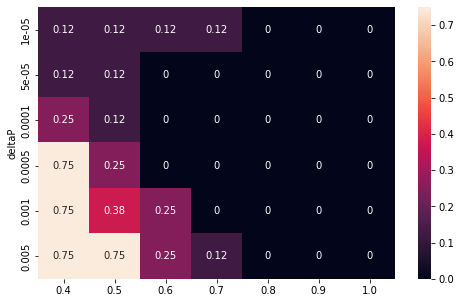

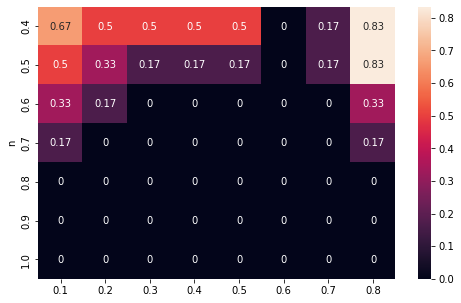

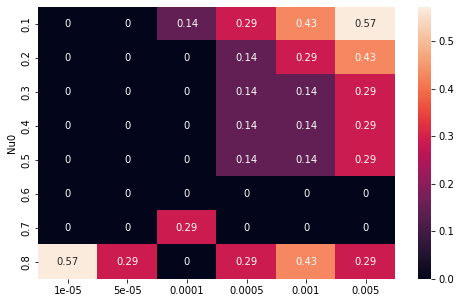

In [ ]:
second=nullcounts_n_deltaP_Nu0(Berea_2)

From the above results, we decided to omit rows with the next lowest power-law exponent (n=0.4) and rows with highest NU_0 (Nu0=0.8) .we call this new dataFrame Berea_3

In [ ]:
Berea_3=Berea_2.drop(Berea_2[Berea_2.Nu0==0.8].index | Berea_2[Berea_2.n==0.4].index)

In [ ]:
Berea_3.head()

deltaP      Umax  ...    categorical_Re     categorical_Umax
112  0.00001  0.000326  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
113  0.00001  0.000164  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
114  0.00001  0.000111  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
115  0.00001  0.000083  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
116  0.00001  0.000067  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]

[5 rows x 10 columns]

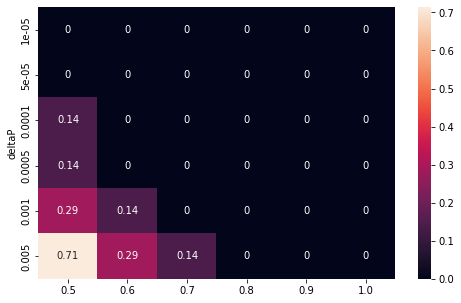

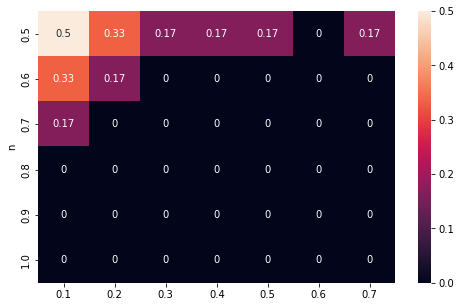

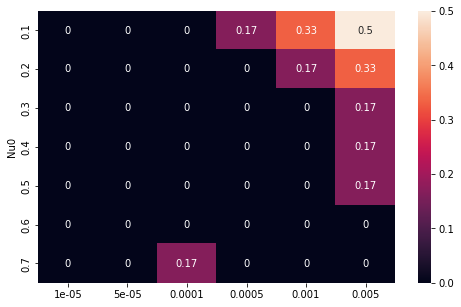

In [ ]:
third=nullcounts_n_deltaP_Nu0(Berea_3)

## Coclusion (for data cleaning part)
 the results indicates that for hugh pressure difference ( almost more than 0.005), law power-law exponent (almost less than 0.5) and high Nu0 value (more than 0.7) the simulation will diverge

# SENSITIVITY ANALYSIS

For the rest of the report; we are going to do some sensitivity analysis; so I decided to omit raws with null values from Berea_3 data frame and call this new data frame Berea_4.

In [ ]:
Berea_3=Berea_2.drop(Berea_2[Berea_2.Nu0==0.8].index | Berea_2[Berea_2.n==0.4].index)

In [ ]:
Berea_4=Berea_3.drop(Berea_3[Berea_3.AvgNu.isnull()].index)

In [ ]:
Berea_4.head()

deltaP      Umax  ...    categorical_Re     categorical_Umax
112  0.00001  0.000326  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
113  0.00001  0.000164  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
114  0.00001  0.000111  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
115  0.00001  0.000083  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]
116  0.00001  0.000067  ...  (-0.0823, 8.885]  (-0.000723, 0.0791]

[5 rows x 10 columns]

In [ ]:
len(Berea_4)

239

In [ ]:
len(Berea)

448

In [ ]:
len(Berea_4)/len(Berea)

0.5334821428571429

Our first version of dataset has 448 raws and Berea_4 which is the 4th version contains 239 raws which means we ommitted abot 47% of data.

## Dependancy of final average viscosity on pressure difference

Now we are ready for sensitivity analysis. first of all;  we decided to check the depandancy of our output (AvgNu) on presssure difference for different n and Nu0 values.

In [ ]:
from scipy.optimize import curve_fit
from matplotlib import pyplot

In [ ]:
pip install lmfit

     |████████████████████████████████| 306 kB 5.1 MB/s 
     |████████████████████████████████| 98 kB 7.6 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-py3-none-any.whl size=85275 sha256=7bd85808ddcefd2c02d5cb27d64c4c245b22e3ff271d2252a692112ae2188712
  Stored in directory: /root/.cache/pip/wheels/42/81/51/72ff0f8e216caa9fe1e9dd1e7c287274b1eb75c79bfc858f5b
  Created wheel for asteval: filename=asteval-0.9.25-py3-none-any.whl size=17301 sha256=8673020c7c87834c3fb420993cc70fde83a747eae16df14d717588a75bb707d7
  Stored in directory: /root/.cache/pip/wheels/4a/87/53/f1385a55b3f60eabb921c5f4fd151c00fdb016b5111b8c830f
Successfully built lmfit asteval


In [ ]:
from lmfit.models import LinearModel

In [ ]:


class pairWise_deltaP_AvgNu_logarithmic:
    def __init__(self, df):
        self.df =df
        
        self.n_counts=df["n"].unique()
        self.Nu0_counts=df["Nu0"].unique()
        
        i=0
        j=0
        
        self.bias=np.zeros((len(self.Nu0_counts),len(self.n_counts)))
        self.slope=np.zeros((len(self.Nu0_counts),len(self.n_counts)))
        
        
        while i< len(self.Nu0_counts):
            self.datas=df.drop(df[df.Nu0!=self.Nu0_counts[i]].index )
            j=0
            while j< len(self.n_counts):
                self.new_data=self.datas.drop(self.datas[self.datas.n!=self.n_counts[j]].index)
                
                plt.figure(figsize=(7,4))
                self.name="n: "+str(self.n_counts[j])+"+"+ "Nu0:"+str(self.Nu0_counts[i])
                #plt.title(name)
                
                model = LinearModel(name=self.name)
                params = model.guess(self.new_data["AvgNu"], x=np.log10(self.new_data["deltaP"]))
                result = model.fit(self.new_data["AvgNu"], params, x=np.log10(self.new_data["deltaP"]))
                self.eq="AvgNu=" + str(result.values["slope"])+"* log(deltaP)  +" + str(result.values["intercept"])
                print(self.eq)
                
                self.slope[i,j]=result.values["slope"]
                self.bias[i,j]=result.values["intercept"]
                
                result.plot_fit()
                plt.show()

                j=j+1
                
            i=i+1
            

In [ ]:
from lmfit.models import LinearModel

class pairWise_deltaP_AvgNu_linear:
    def __init__(self, df):
        self.df =df
        
        self.n_counts=df["n"].unique()
        self.Nu0_counts=df["Nu0"].unique()
        
        i=0
        j=0

        self.bias=np.zeros((len(self.Nu0_counts),len(self.n_counts)))
        self.slope=np.zeros((len(self.Nu0_counts),len(self.n_counts)))
        
        
        while i< len(self.Nu0_counts):
            self.datas=df.drop(df[df.Nu0!=self.Nu0_counts[i]].index )
            j=0
            while j< len(self.n_counts):
                self.new_data=self.datas.drop(self.datas[self.datas.n!=self.n_counts[j]].index)
                
                plt.figure(figsize=(7,4))
                self.name="n: "+str(self.n_counts[j])+"+"+ "Nu0:"+str(self.Nu0_counts[i])
                #plt.title(name)
                
                model = LinearModel(name=self.name)
                params = model.guess(self.new_data["AvgNu"], x=self.new_data["deltaP"])
                result = model.fit(self.new_data["AvgNu"], params, x=self.new_data["deltaP"])
                self.eq="AvgNu =" + str(result.values["slope"])+"* deltaP +" + str(result.values["intercept"])
                print(self.eq)
                
                self.slope[i,j]=result.values["slope"]
                self.bias[i,j]=result.values["intercept"]
                
                result.plot_fit()
                plt.show()

                j=j+1
                
            i=i+1
            

NuMean =124.51639344262209* deltaP +0.14596245901639351


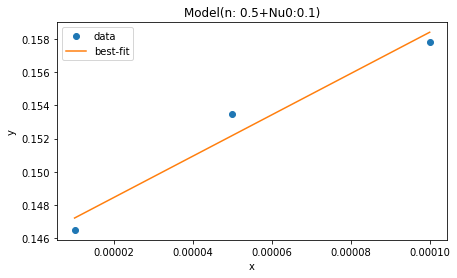

NuMean =31.722836694860042* deltaP +0.1604657319453481


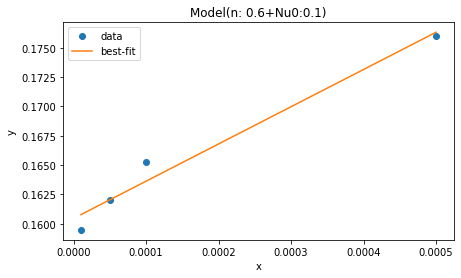

NuMean =16.481081688873765* deltaP +0.18378228087929385


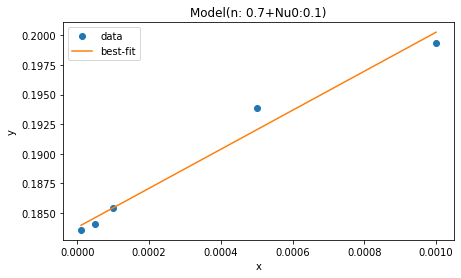

NuMean =2.2516216216216214* deltaP +0.21961069999999994


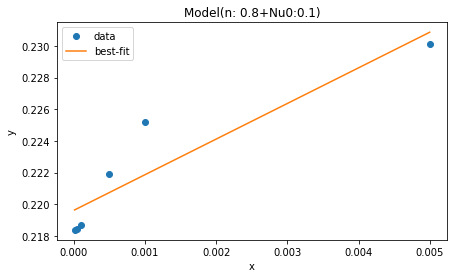

NuMean =0.9127186009538879* deltaP +0.2615052156862744


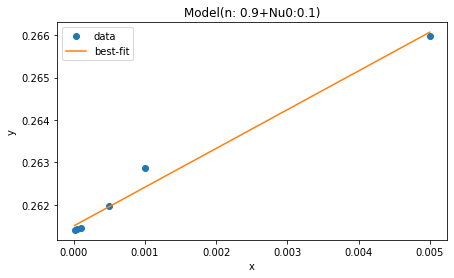

NuMean =0.0* deltaP +0.31067


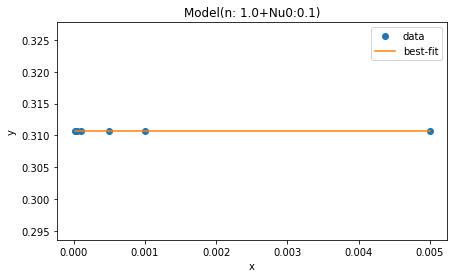

NuMean =43.797332465842516* deltaP +0.15805594014313598


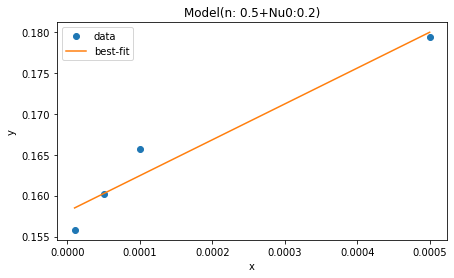

NuMean =27.238601225614158* deltaP +0.18429478439309604


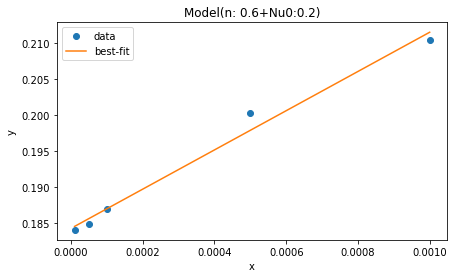

NuMean =6.679777424483323* deltaP +0.2355421137254901


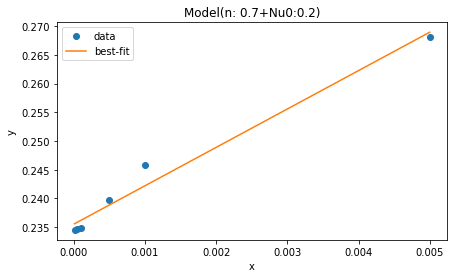

NuMean =3.2098198198197925* deltaP +0.3042520999999999


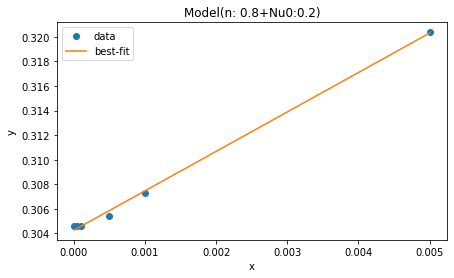

NuMean =0.7617117117117046* deltaP +0.39071616666666664


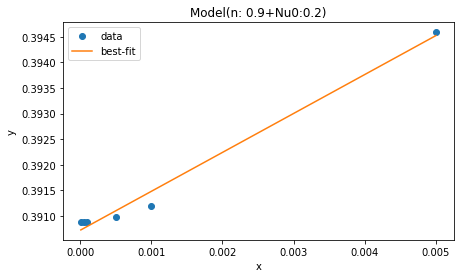

NuMean =1.297236904321339e-14* deltaP +0.48968


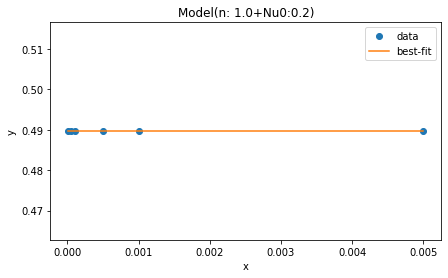

NuMean =35.00163040422766* deltaP +0.16793345870579637


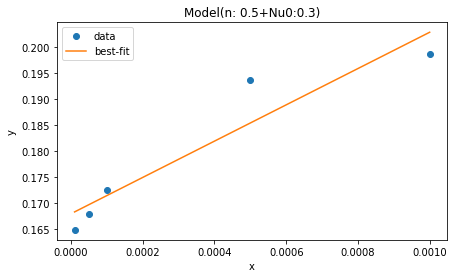

NuMean =10.267233704292504* deltaP +0.21248837058823528


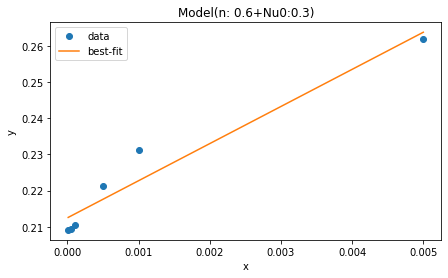

NuMean =6.547329093799673* deltaP +0.2850941313725489


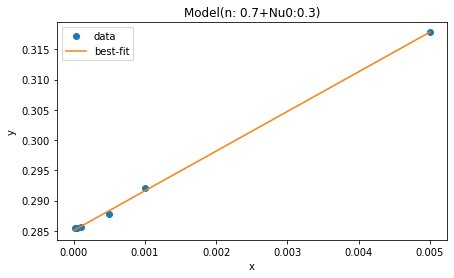

NuMean =2.4251934287228014* deltaP +0.39015136862745087


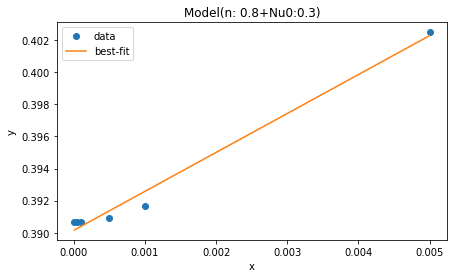

NuMean =0.4211923688394379* deltaP +0.5201291431372546


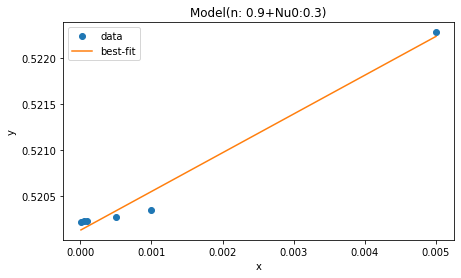

NuMean =-5.021519763157562e-14* deltaP +0.66868


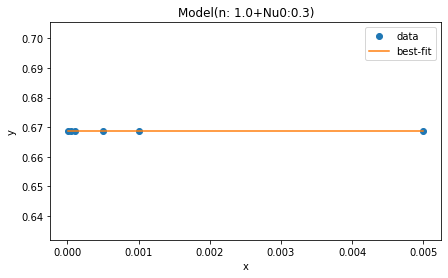

NuMean =40.8064597739921* deltaP +0.17532425535503457


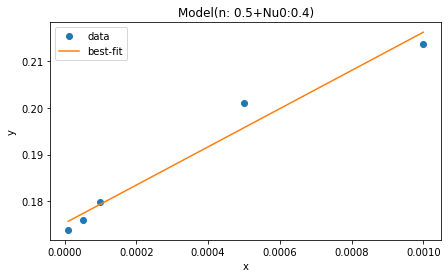

NuMean =11.197541070482243* deltaP +0.23588739607843126


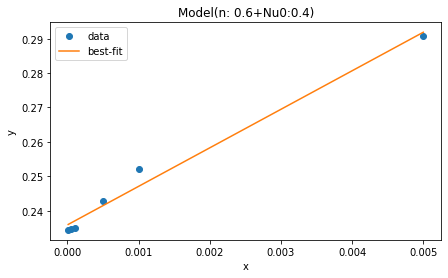

NuMean =5.5638526762056* deltaP +0.3355607901960784


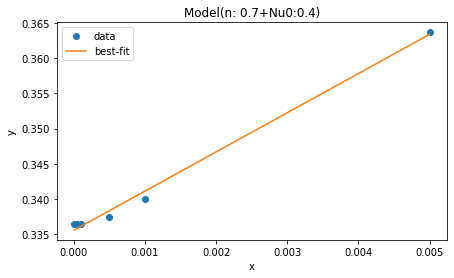

NuMean =1.6000900900900517* deltaP +0.4763188999999999


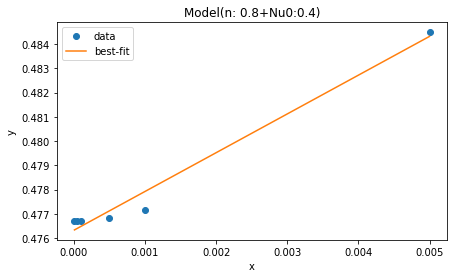

NuMean =0.21958134605192167* deltaP +0.6494779313725488


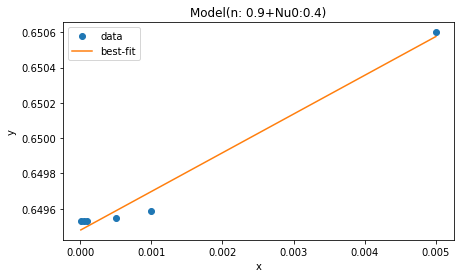

NuMean =-2.3029242847083022e-14* deltaP +0.8476799999999999


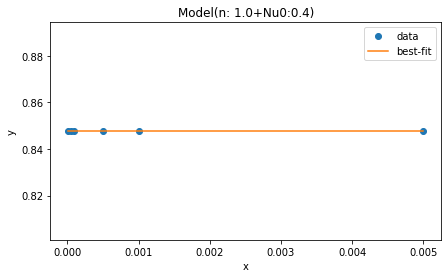

NuMean =40.37465564738276* deltaP +0.18354961432506883


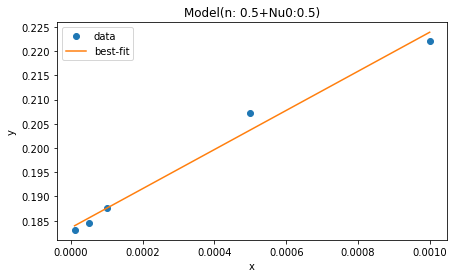

NuMean =10.821436142024385* deltaP +0.2600915392156862


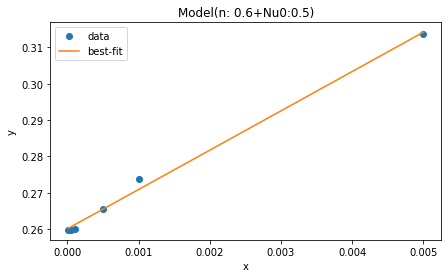

NuMean =4.525696873343901* deltaP +0.38645314313725476


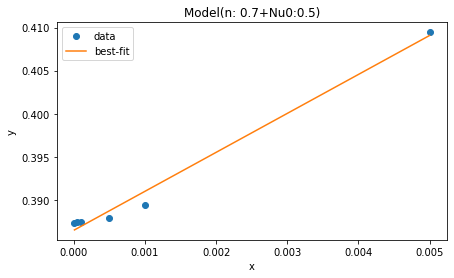

NuMean =1.0142077371488971* deltaP +0.5624858960784314


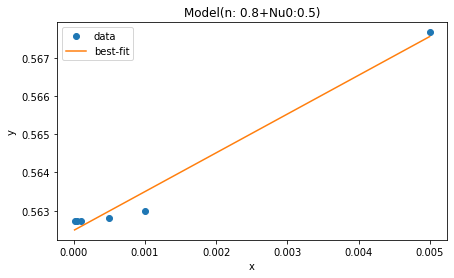

NuMean =0.12519342872278383* deltaP +0.7787210352941174


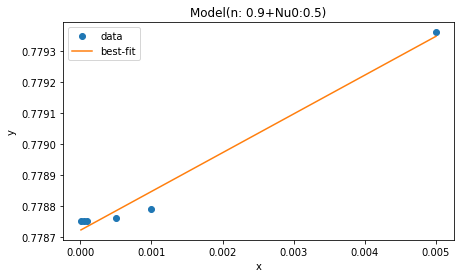

NuMean =-3.647632853779421e-15* deltaP +1.0267


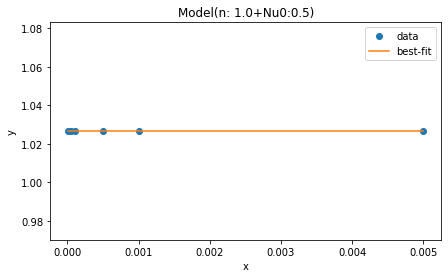

NuMean =-91.44289878113409* deltaP +1.2089266176470583


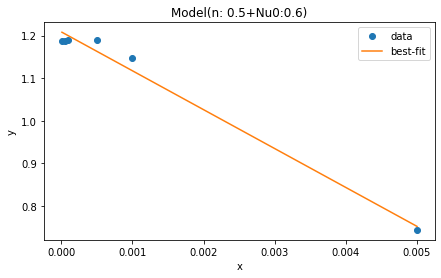

NuMean =-67.93749867514586* deltaP +1.2070206235294116


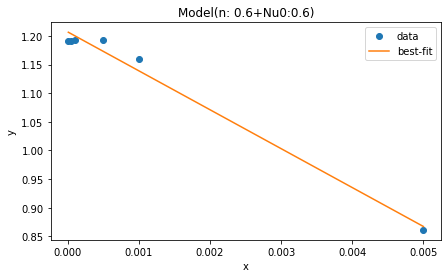

NuMean =-47.50042925278228* deltaP +1.205860476470588


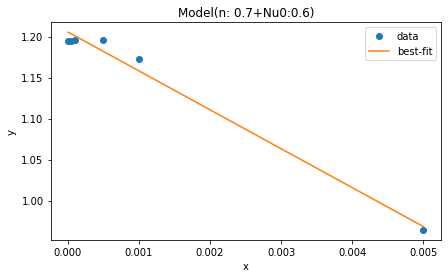

NuMean =-29.706253312135683* deltaP +1.2053072745098035


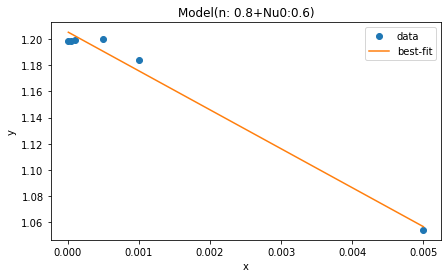

NuMean =-14.014573396926277* deltaP +1.2052061764705877


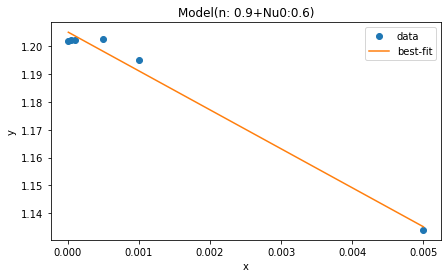

NuMean =-2.722390591430344e-14* deltaP +1.2057


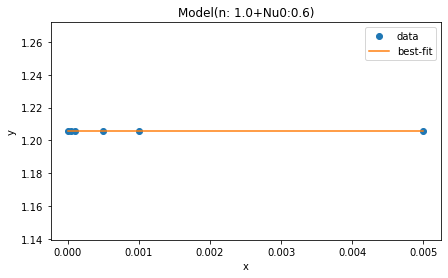

NuMean =-96.0983663042024* deltaP +1.4139850565911132


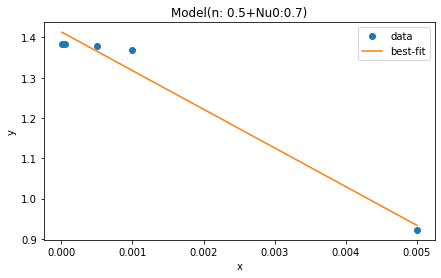

NuMean =-54.29379968203505* deltaP +1.3357494509803922


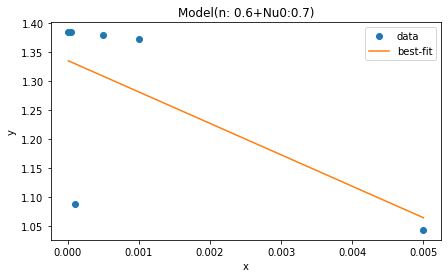

NuMean =-37.95638579756239* deltaP +1.3503315882352942


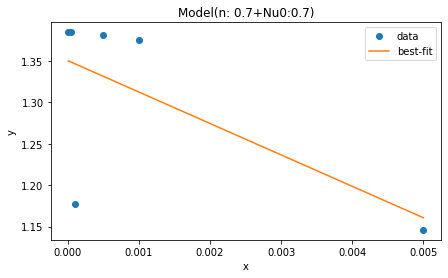

NuMean =-23.761950185479538* deltaP +1.3629257647058817


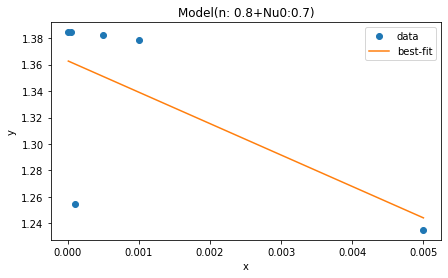

NuMean =-11.236777954424998* deltaP +1.374089490196078


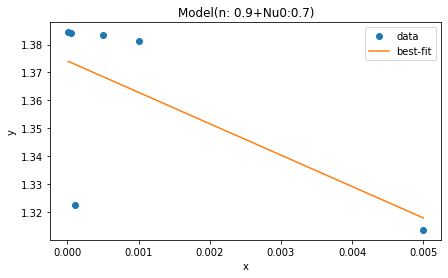

NuMean =-9.938505147342939e-14* deltaP +1.3847


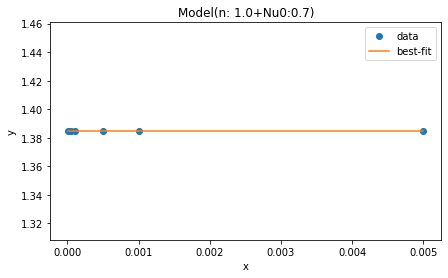

In [ ]:
deltaP_AvgNu_linear=pairWise_deltaP_AvgNu_linear(Berea_4)

Text(69.0, 0.5, 'Nu0')

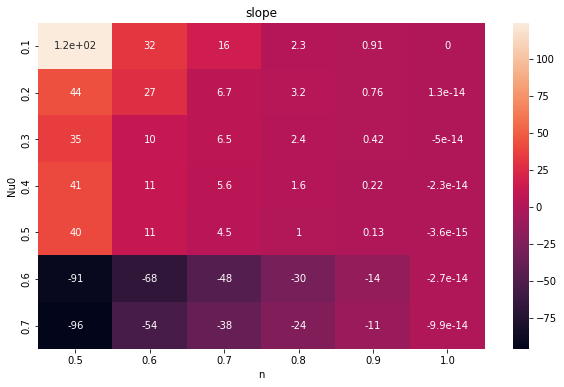

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(deltaP_AvgNu_linear.slope,xticklabels=list(map(lambda i:str(i),deltaP_AvgNu_linear.n_counts)), yticklabels=list(map(lambda i:str(i),deltaP_AvgNu_linear.Nu0_counts)),annot=True)
p.set_xlabel("n")
p.set_ylabel("Nu0")

NuMean=0.011112293686701746* log(deltaP)  +0.20187165054914918


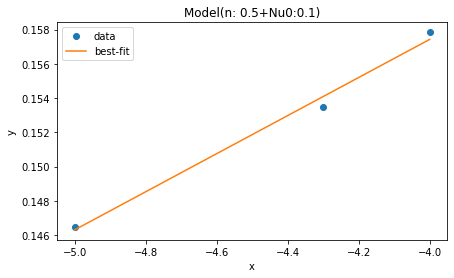

NuMean=0.009773310882806129* log(deltaP)  +0.20626427339756143


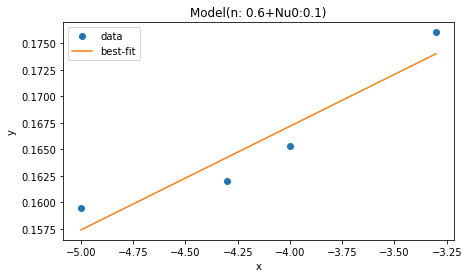

NuMean=0.008082790526878087* log(deltaP)  +0.22094186896104034


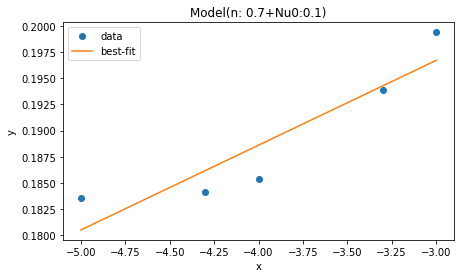

NuMean=0.004518162908820275* log(deltaP)  +0.2386036214612966


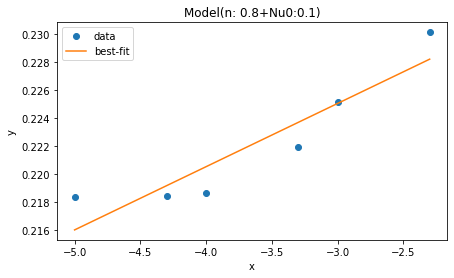

NuMean=0.0015421253869058234* log(deltaP)  +0.26814788518677046


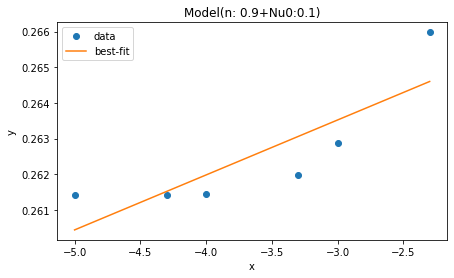

NuMean=0.0* log(deltaP)  +0.31067


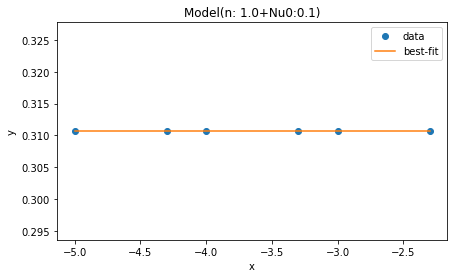

NuMean=0.013988833060979993* log(deltaP)  +0.2233433614217655


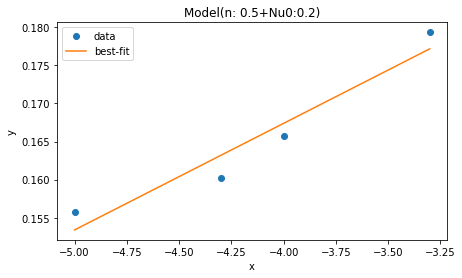

NuMean=0.013225192482287445* log(deltaP)  +0.2451862032869316


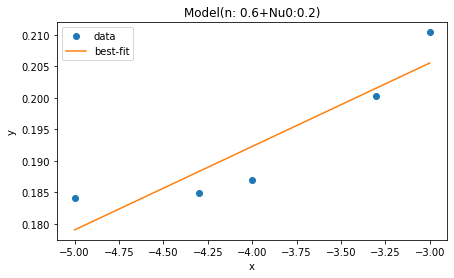

NuMean=0.01149013206452997* log(deltaP)  +0.28490156609530354


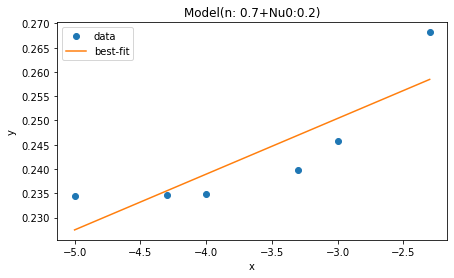

NuMean=0.004939394505843835* log(deltaP)  +0.3258463337237918


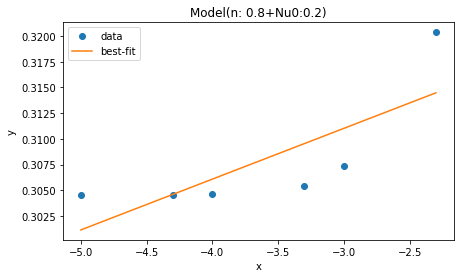

NuMean=0.0011134338401215798* log(deltaP)  +0.3956262735991241


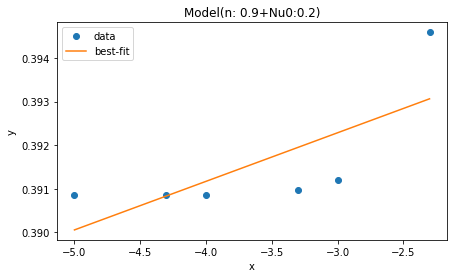

NuMean=-5.357514638844978e-33* log(deltaP)  +0.48968


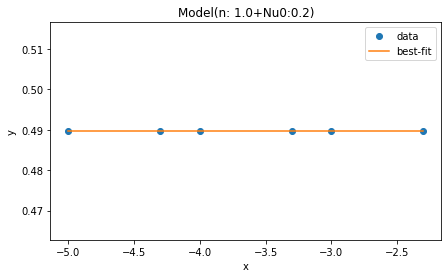

NuMean=0.018602006932128344* log(deltaP)  +0.2524815311685357


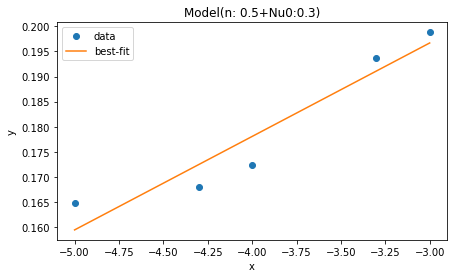

NuMean=0.01882485031969521* log(deltaP)  +0.29260539842398964


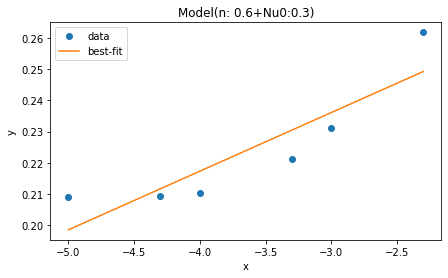

NuMean=0.010271027646286067* log(deltaP)  +0.32985620713258096


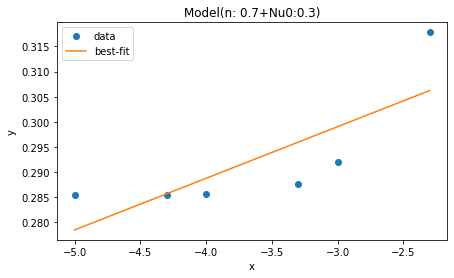

NuMean=0.0035374740694636875* log(deltaP)  +0.40575693547835223


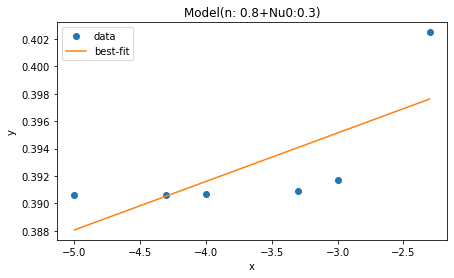

NuMean=0.0006068198277506868* log(deltaP)  +0.5228118715488523


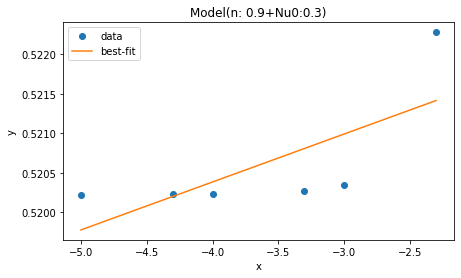

NuMean=3.2145087833069867e-32* log(deltaP)  +0.66868


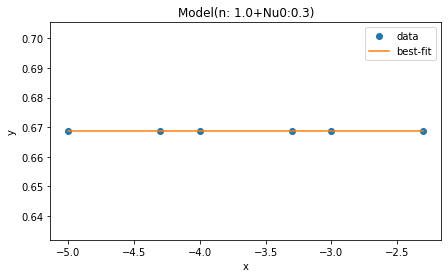

NuMean=0.02039756434958896* log(deltaP)  +0.26883885601152313


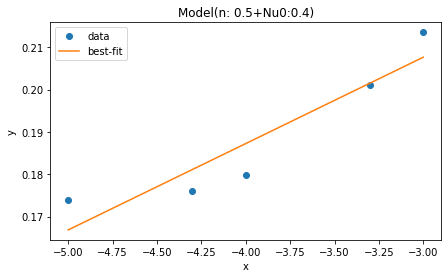

NuMean=0.019070798525128625* log(deltaP)  +0.31793490270328084


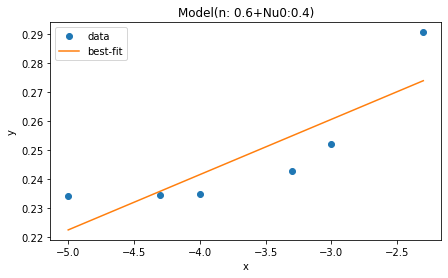

NuMean=0.008340721749906722* log(deltaP)  +0.37218459650744445


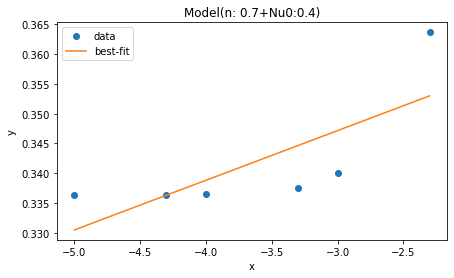

NuMean=0.002299605835942601* log(deltaP)  +0.48648974559321034


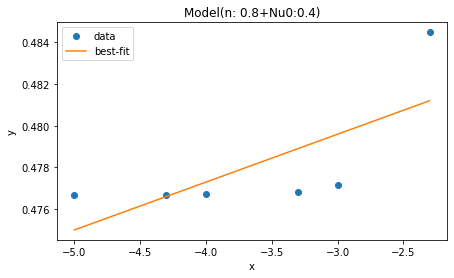

NuMean=0.0003148152045779891* log(deltaP)  +0.650870904292524


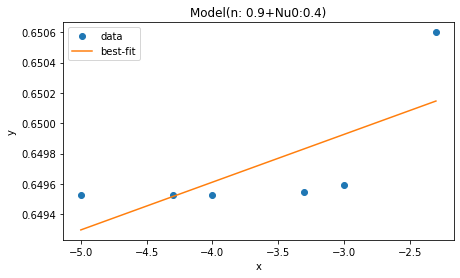

NuMean=-6.429017566613973e-32* log(deltaP)  +0.8476799999999999


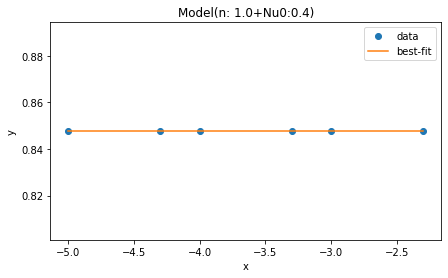

NuMean=0.019654734485417304* log(deltaP)  +0.27400865689935455


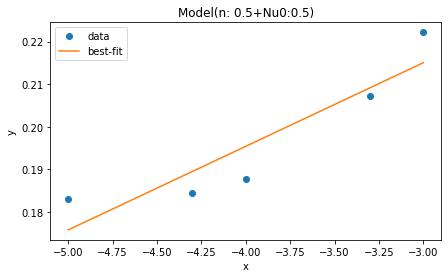

NuMean=0.01766585266410133* log(deltaP)  +0.3365927934331254


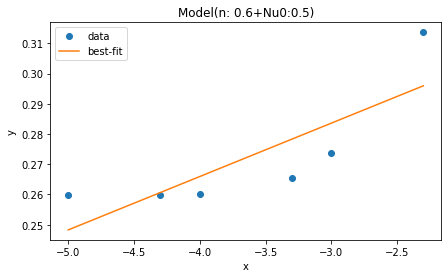

NuMean=0.006623803110828978* log(deltaP)  +0.415656959265434


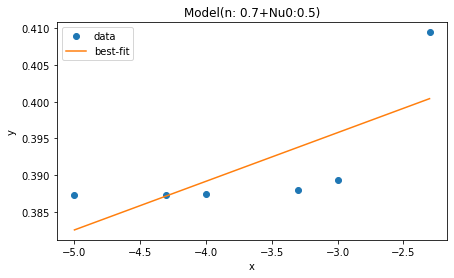

NuMean=0.0014515715282696702* log(deltaP)  +0.5689106503010408


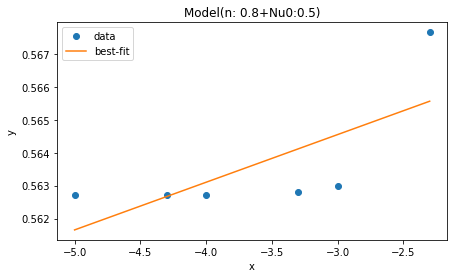

NuMean=0.00018016699347776023* log(deltaP)  +0.7795177023118047


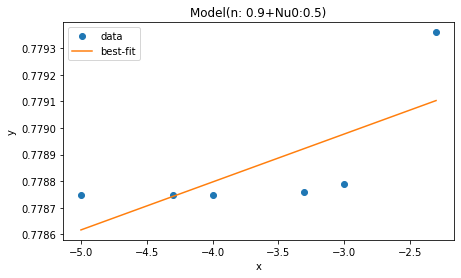

NuMean=2.143005855537991e-32* log(deltaP)  +1.0267


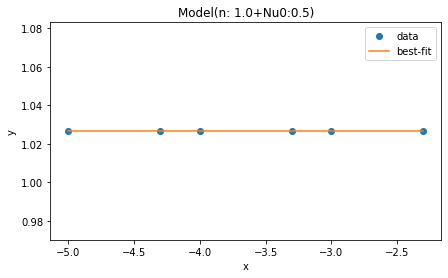

NuMean=-0.1318595855063884* log(deltaP)  +0.6260696055010192


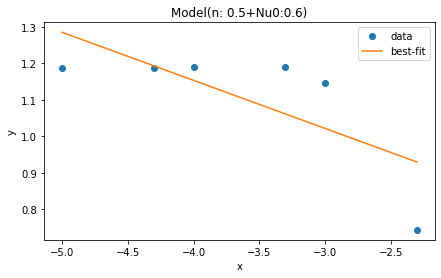

NuMean=-0.0981156554763026* log(deltaP)  +0.7734373281616408


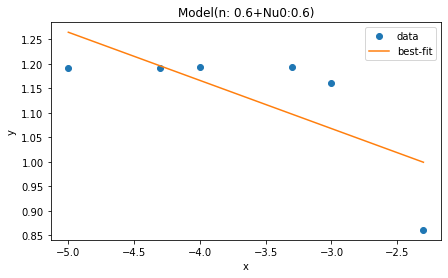

NuMean=-0.06872613288972725* log(deltaP)  +0.902249221143056


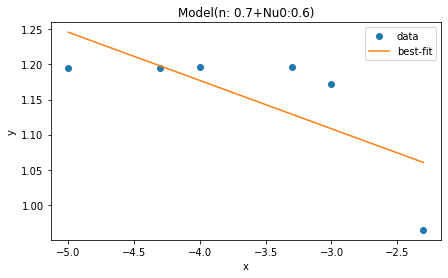

NuMean=-0.04302987688214808* log(deltaP)  +1.0152521224201876


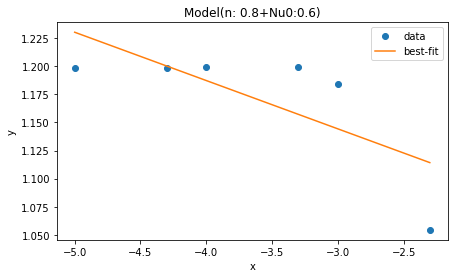

NuMean=-0.020328971206118648* log(deltaP)  +1.1154387857215684


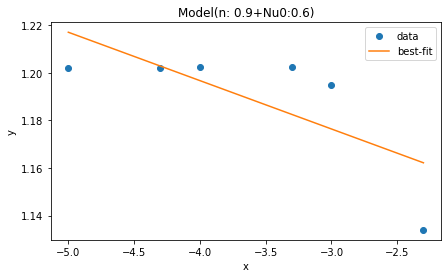

NuMean=1.7144046844303929e-31* log(deltaP)  +1.2057


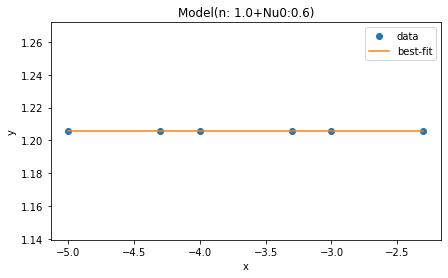

NuMean=-0.13121365783000896* log(deltaP)  +0.8180780152693962


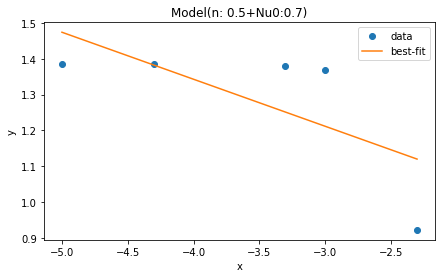

NuMean=-0.07743682544884478* log(deltaP)  +0.9927990406478272


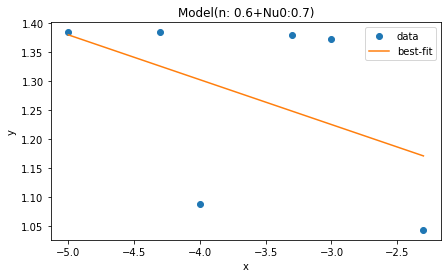

NuMean=-0.05422682616549002* log(deltaP)  +1.1102441577980504


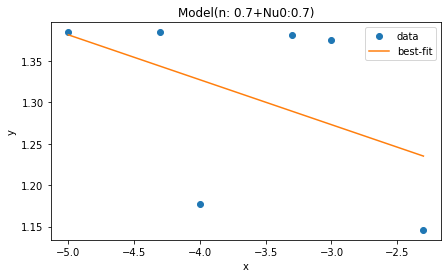

NuMean=-0.034036004210873834* log(deltaP)  +1.212301056161932


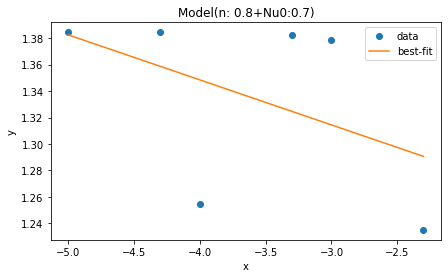

NuMean=-0.016117461412748474* log(deltaP)  +1.30277963205245


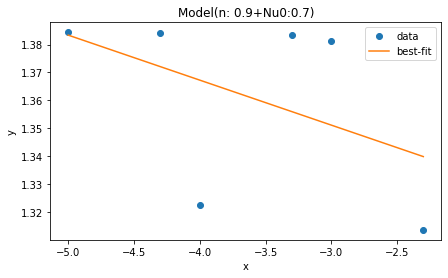

NuMean=-6.429017566613973e-32* log(deltaP)  +1.3847


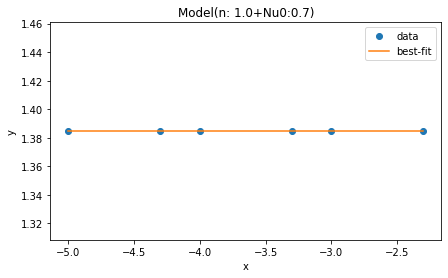

In [ ]:
deltaP_AvgNu_logarithmic=pairWise_deltaP_AvgNu_logarithmic(Berea_4)

Text(69.0, 0.5, 'Nu0')

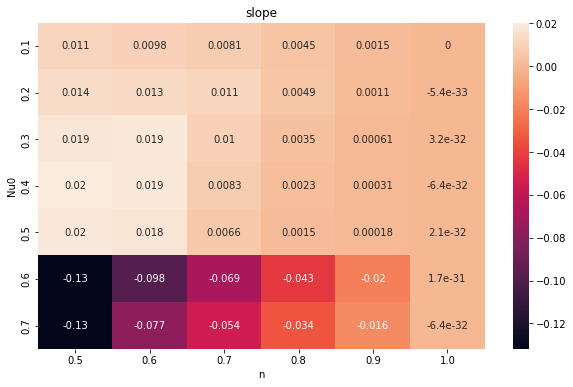

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(deltaP_AvgNu_logarithmic.slope,xticklabels=list(map(lambda i:str(i),deltaP_AvgNu_logarithmic.n_counts)), yticklabels=list(map(lambda i:str(i),deltaP_AvgNu_logarithmic.Nu0_counts)),annot=True)
p.set_xlabel("n")
p.set_ylabel("Nu0")

### coculsion for change average viscosity with pressure difference

1-It seems that the when we increase the non-Newtonian behavior of the fluid (deviation from 1 for power-law exponent) the dependacy of average viscosity with pressure difference becomes more significant. The reason forthis phenomenon is the th calculated shear-rate depends on velocity and the velocity in this example was calculated based n pressure difference.

2-With increasing Nu0 (viscosity at zero shear rate and also at the initial state of simulation); there was a general increase in the dependancy of the result on pressure difference. Alo; it seems that there is a transient state in (between 0.5 and 0.6) which the depedancy changes from positive to negative value, (WHY?) 

## Dependancy of final average viscosity on Nu0

After Pressure difference; it is time to check the depandancy of our output (AvgNu) on presssure difference for different n and Nu0 values.

In [ ]:
from lmfit.models import LinearModel

class pairWise_Nu0_AvgNu_logarithmic:
    def __init__(self, df):
        self.df =df
        
        self.n_counts=df["n"].unique()
        self.deltaP_counts=df["deltaP"].unique()
        
        i=0
        j=0
        
        self.bias=np.zeros((len(self.deltaP_counts),len(self.n_counts)))
        self.slope=np.zeros((len(self.deltaP_counts),len(self.n_counts)))
        
        
        while i< len(self.deltaP_counts):
            self.datas=df.drop(df[df.deltaP!=self.deltaP_counts[i]].index )
            j=0
            while j< len(self.n_counts):
                self.new_data=self.datas.drop(self.datas[self.datas.n!=self.n_counts[j]].index)
                
                plt.figure(figsize=(7,4))
                self.name="n: "+str(self.n_counts[j])+"+"+ "deltaP:"+str(self.deltaP_counts[i])
                #plt.title(name)
                
                model = LinearModel(name=self.name)
                params = model.guess(np.log10(self.new_data["AvgNu"]), x=self.new_data["Nu0"])
                result = model.fit(np.log10(self.new_data["AvgNu"]), params, x=self.new_data["Nu0"])
                self.eq="log(AvgNu) =" + str(result.values["slope"])+"* Nu0  +" + str(result.values["intercept"])
                print(self.eq)
                
                self.slope[i,j]=result.values["slope"]
                self.bias[i,j]=result.values["intercept"]
                
                result.plot_fit()
                plt.show()

                j=j+1
                
            i=i+1
            

In [ ]:
from lmfit.models import LinearModel

class pairWise_Nu0_AvgNu_linear:
    def __init__(self, df):
        self.df =df
        
        self.n_counts=df["n"].unique()
        self.deltaP_counts=df["deltaP"].unique()
        
        i=0
        j=0
        
        self.bias=np.zeros((len(self.deltaP_counts),len(self.n_counts)))
        self.slope=np.zeros((len(self.deltaP_counts),len(self.n_counts)))
        
        
        while i< len(self.deltaP_counts):
            self.datas=df.drop(df[df.deltaP!=self.deltaP_counts[i]].index )
            j=0
            while j< len(self.n_counts):
                self.new_data=self.datas.drop(self.datas[self.datas.n!=self.n_counts[j]].index)
                
                plt.figure(figsize=(7,4))
                self.name="n: "+str(self.n_counts[j])+"+"+ "deltaP:"+str(self.deltaP_counts[i])
                #plt.title(name)
                
                model = LinearModel(name=self.name)
                params = model.guess(self.new_data["AvgNu"], x=self.new_data["Nu0"])
                result = model.fit(self.new_data["AvgNu"], params, x=self.new_data["Nu0"])
                self.eq="AvgNu = "+str(result.values["slope"])+"* Nu0  +" + str(result.values["intercept"])
                print(self.eq)
                
                self.slope[i,j]=result.values["slope"]
                self.bias[i,j]=result.values["intercept"]
                
                result.plot_fit()
                plt.show()

                j=j+1
                
            i=i+1
            

NuMean = 2.069389285714286* Nu0  +-0.3426985714285713


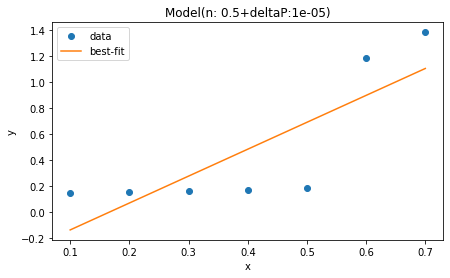

NuMean = 2.0496214285714287* Nu0  +-0.3024099999999999


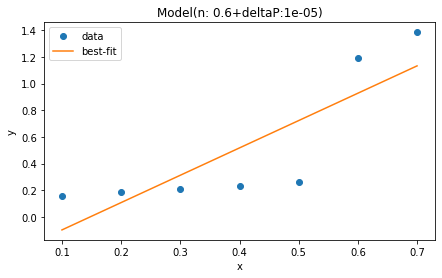

NuMean = 2.008867857142857* Nu0  +-0.23119999999999952


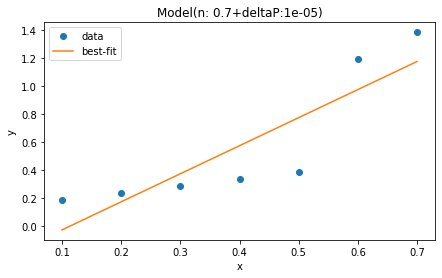

NuMean = 1.9492607142857148* Nu0  +-0.13173142857142842


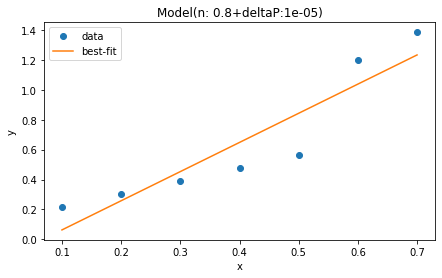

NuMean = 1.8748428571428575* Nu0  +-0.008925714285714127


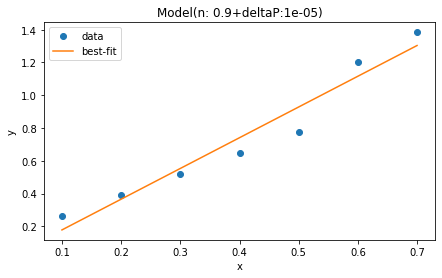

NuMean = 1.7900535714285721* Nu0  +0.13166571428571444


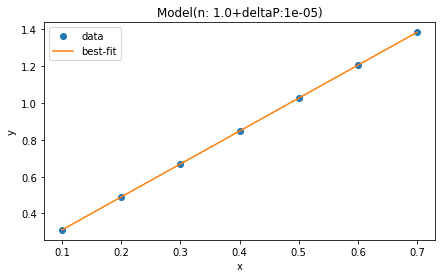

NuMean = 2.058407142857143* Nu0  +-0.3356385714285712


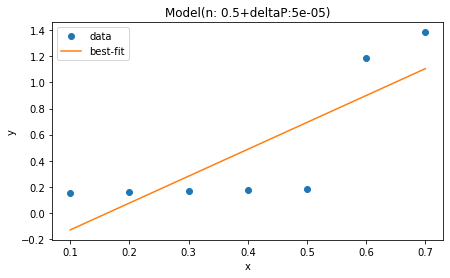

NuMean = 2.0465107142857146* Nu0  +-0.300512857142857


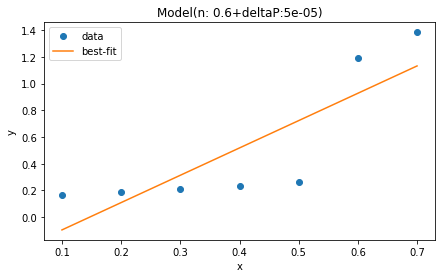

NuMean = 2.0083857142857147* Nu0  +-0.23086428571428558


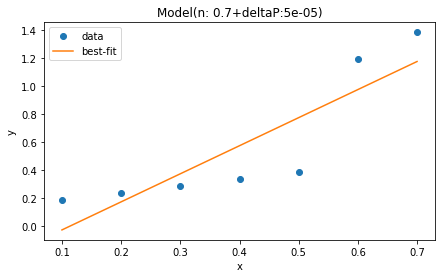

NuMean = 1.9492785714285719* Nu0  +-0.13169714285714268


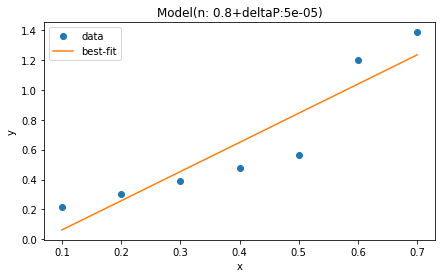

NuMean = 1.8748642857142863* Nu0  +-0.008917142857142622


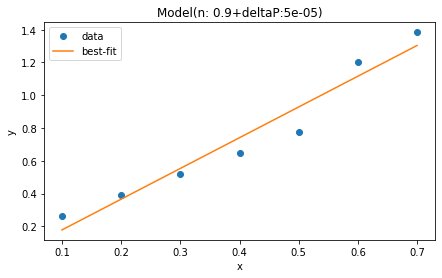

NuMean = 1.7900535714285721* Nu0  +0.13166571428571444


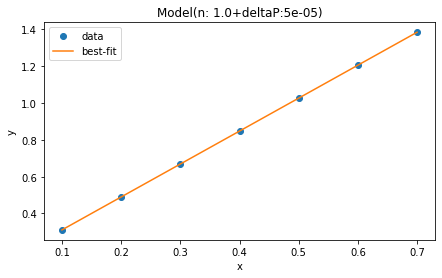

NuMean = 1.4944428571428574* Nu0  +-0.1809066666666666


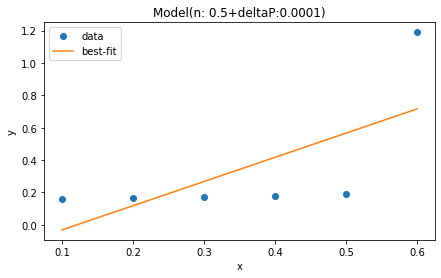

NuMean = 1.725089285714286* Nu0  +-0.21306428571428554


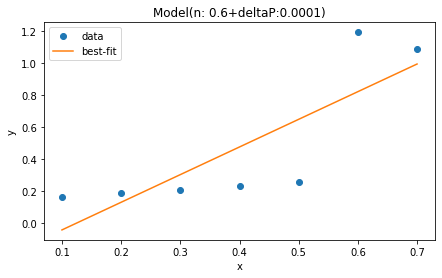

NuMean = 1.7859714285714283* Nu0  +-0.17106142857142834


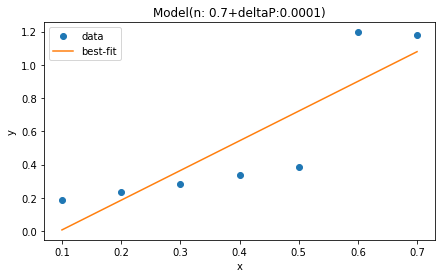

NuMean = 1.8104928571428571* Nu0  +-0.09458857142857101


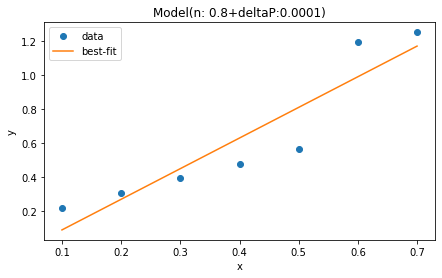

NuMean = 1.8090464285714285* Nu0  +0.00865714285714317


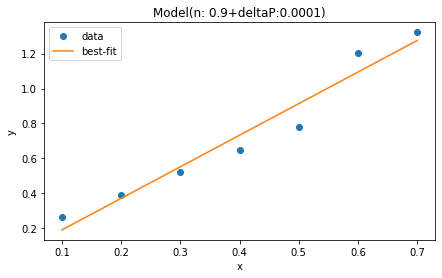

NuMean = 1.7900535714285721* Nu0  +0.13166571428571444


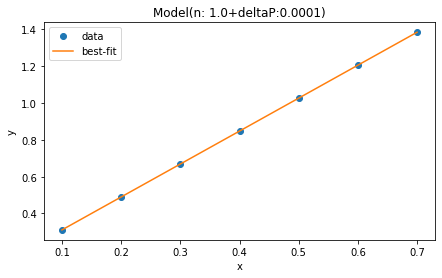

NuMean = 2.5702514285714284* Nu0  +-0.5981431428571434


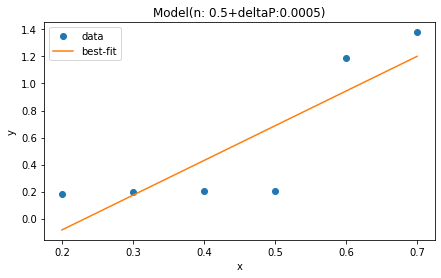

NuMean = 2.0154214285714285* Nu0  +-0.2805357142857138


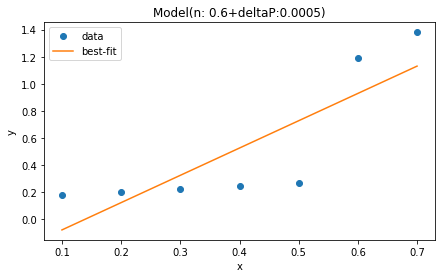

NuMean = 1.991607142857143* Nu0  +-0.22170857142857103


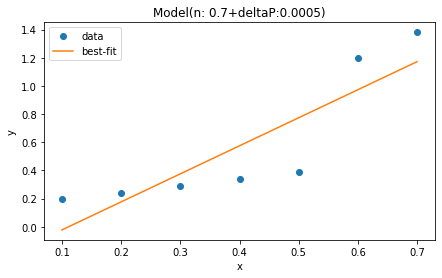

NuMean = 1.9434071428571433* Nu0  +-0.12882142857142845


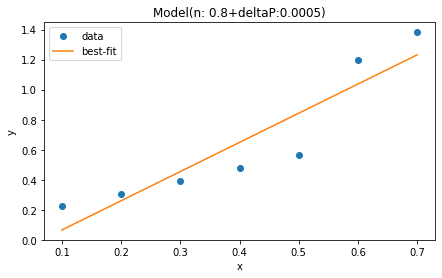

NuMean = 1.8735142857142861* Nu0  +-0.008345714285714059


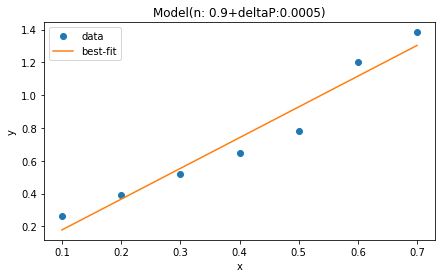

NuMean = 1.7900535714285721* Nu0  +0.13166571428571444


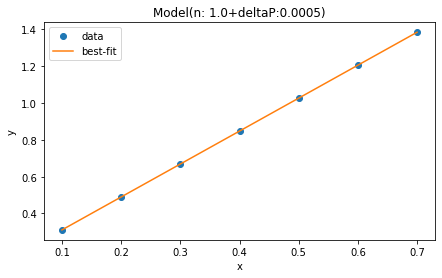

NuMean = 3.274340000000001* Nu0  +-1.0069580000000005


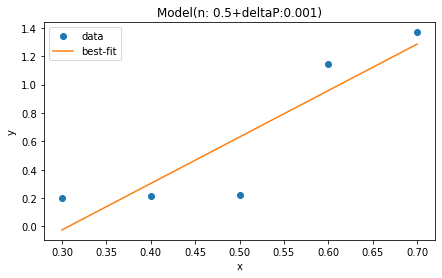

NuMean = 2.462177142857143* Nu0  +-0.5246363809523815


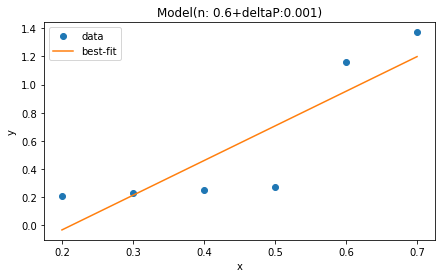

NuMean = 1.9566035714285717* Nu0  +-0.20915142857142818


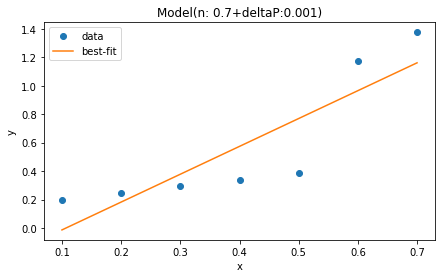

NuMean = 1.9229535714285717* Nu0  +-0.12250428571428554


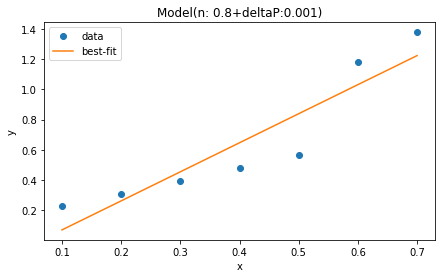

NuMean = 1.8647500000000006* Nu0  +-0.006027142857142613


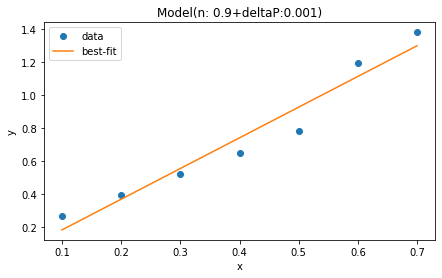

NuMean = 1.7900535714285721* Nu0  +0.13166571428571444


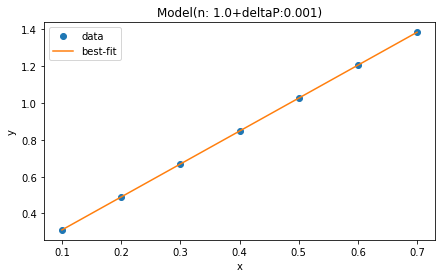

NuMean = 1.7877000000000007* Nu0  +-0.32917000000000035


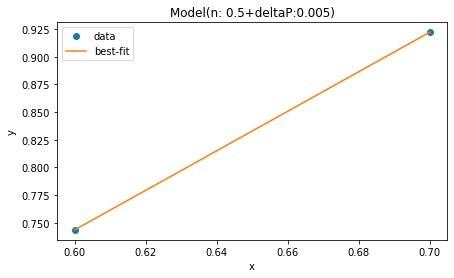

NuMean = 2.13323* Nu0  +-0.5124390000000001


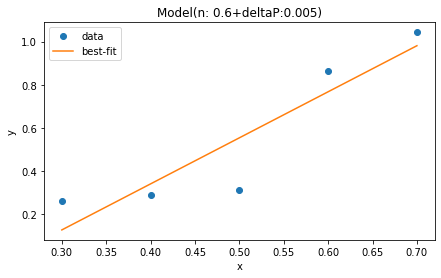

NuMean = 1.8211* Nu0  +-0.2412700000000003


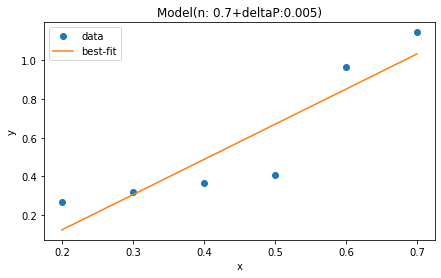

NuMean = 1.6598750000000004* Nu0  +-0.05045714285714266


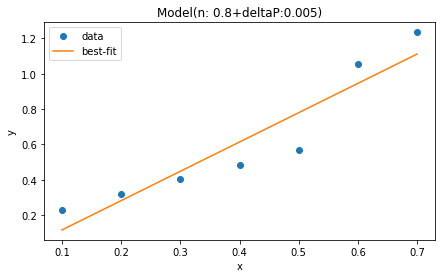

NuMean = 1.7424142857142864* Nu0  +0.025949999999999977


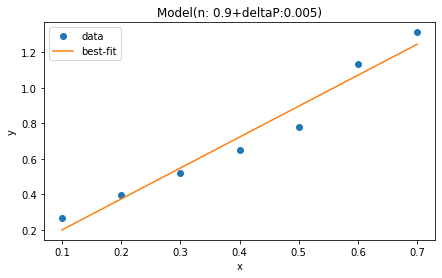

NuMean = 1.7900535714285721* Nu0  +0.13166571428571444


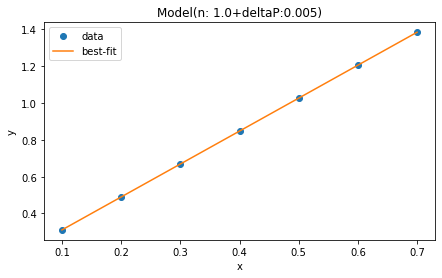

In [ ]:
Nu0_AvgNu_linear=pairWise_Nu0_AvgNu_linear(Berea_4)

Text(69.0, 0.5, 'deltaP')

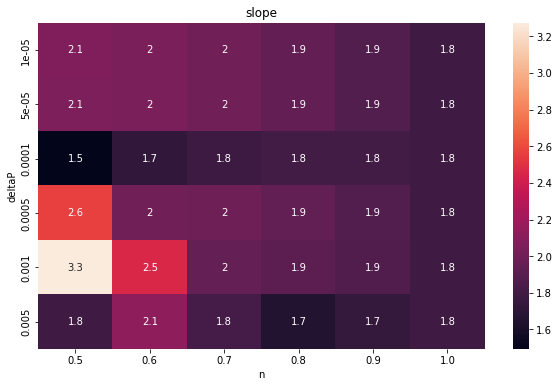

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(Nu0_AvgNu_linear.slope,xticklabels=list(map(lambda i:str(i),Nu0_AvgNu_linear.n_counts)), yticklabels=list(map(lambda i:str(i),Nu0_AvgNu_linear.deltaP_counts)),annot=True)
p.set_xlabel("n")
p.set_ylabel("deltaP")

Text(69.0, 0.5, 'deltaP')

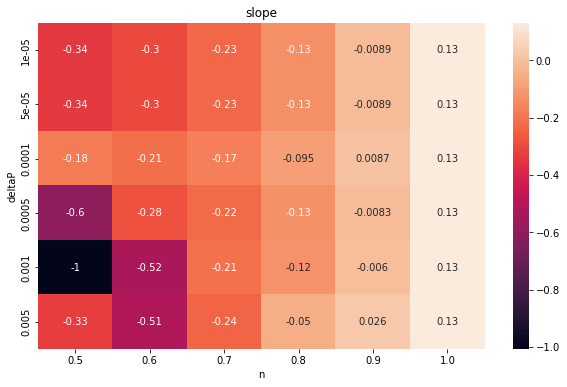

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(Nu0_AvgNu_linear.bias,xticklabels=list(map(lambda i:str(i),Nu0_AvgNu_linear.n_counts)), yticklabels=list(map(lambda i:str(i),Nu0_AvgNu_linear.deltaP_counts)),annot=True)
p.set_xlabel("n")
p.set_ylabel("deltaP")

log(NuMean) =1.6913215816709886* Nu0  +-1.2059541226169015


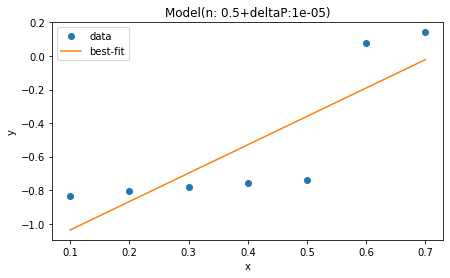

log(NuMean) =1.6184015543260926* Nu0  +-1.1059621055802942


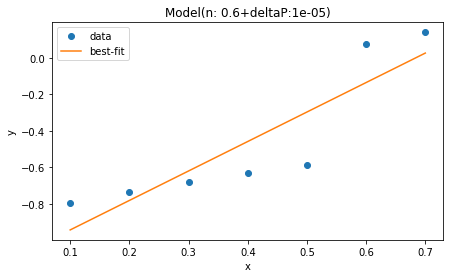

log(NuMean) =1.4925431496780919* Nu0  +-0.965154392948681


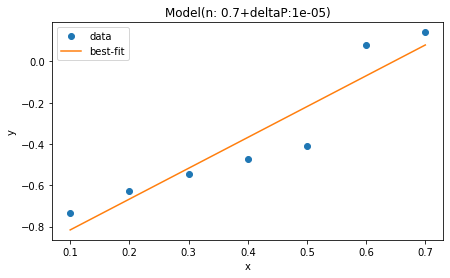

log(NuMean) =1.3409175249989562* Nu0  +-0.8130723592105765


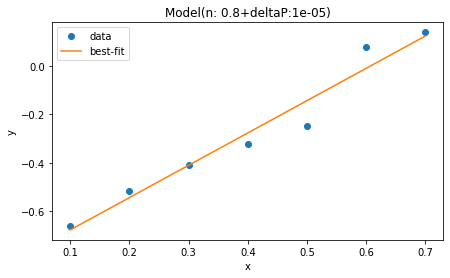

log(NuMean) =1.1866789957966954* Nu0  +-0.6674332010538679


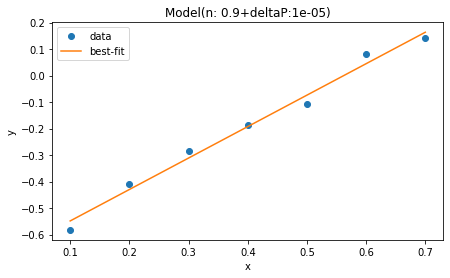

log(NuMean) =1.041445764793749* Nu0  +-0.5351925245667004


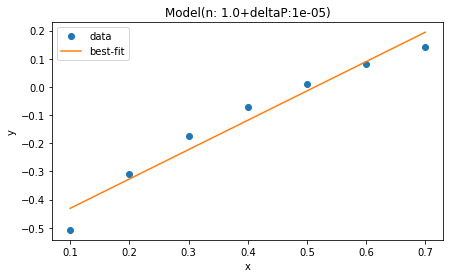

log(NuMean) =1.6593199673794425* Nu0  +-1.1860678016132706


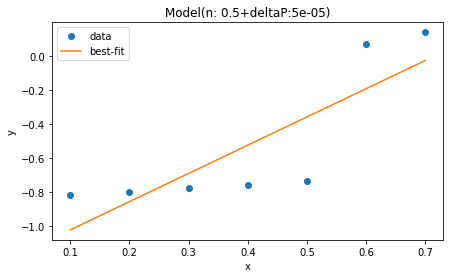

log(NuMean) =1.6095059156533837* Nu0  +-1.1009208823620535


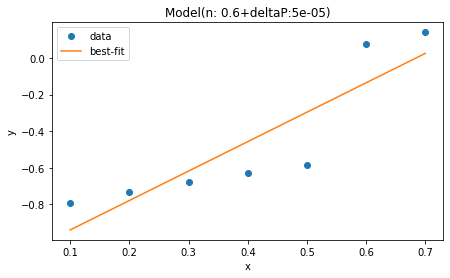

log(NuMean) =1.4910965617347451* Nu0  +-0.9643386334731386


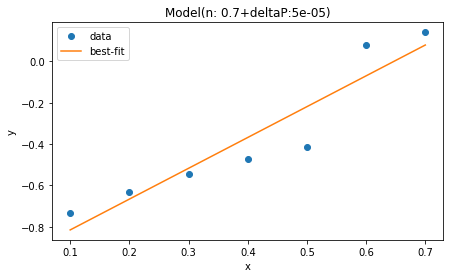

log(NuMean) =1.3407920618643099* Nu0  +-0.8129871659646435


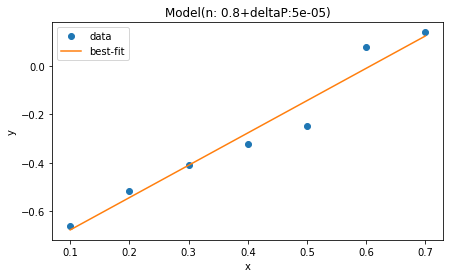

log(NuMean) =1.1866762175517271* Nu0  +-0.66742268237358


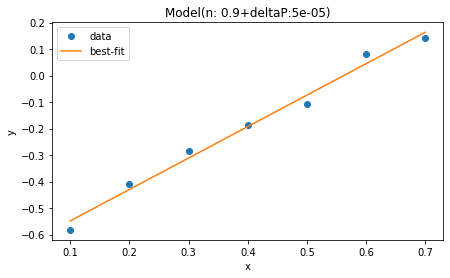

log(NuMean) =1.041445764793749* Nu0  +-0.5351925245667004


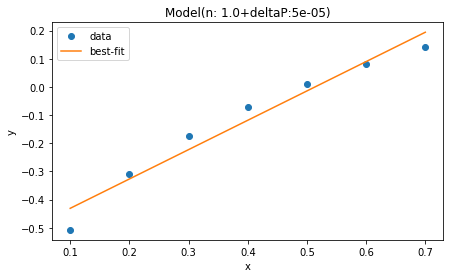

log(NuMean) =1.3044775840404885* Nu0  +-1.0802338412410866


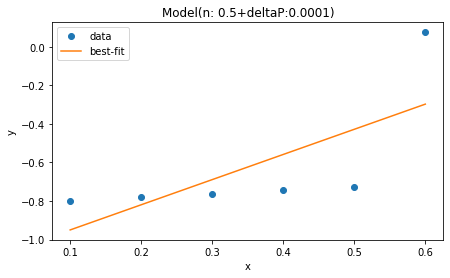

log(NuMean) =1.484738970623119* Nu0  +-1.0635225329510842


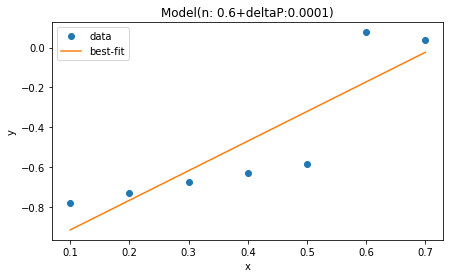

log(NuMean) =1.4125164608947947* Nu0  +-0.9423722959291875


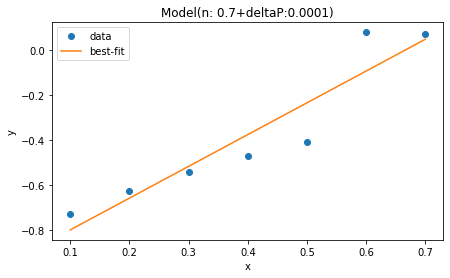

log(NuMean) =1.2946924228521222* Nu0  +-0.8005507434785107


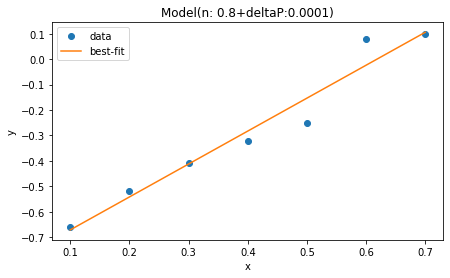

log(NuMean) =1.1655193022882848* Nu0  +-0.6617614389936073


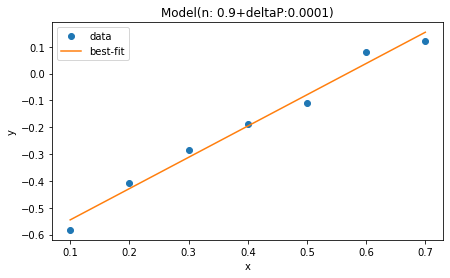

log(NuMean) =1.041445764793749* Nu0  +-0.5351925245667004


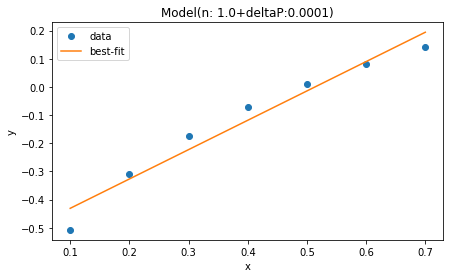

log(NuMean) =1.945315065024168* Nu0  +-1.312752813113056


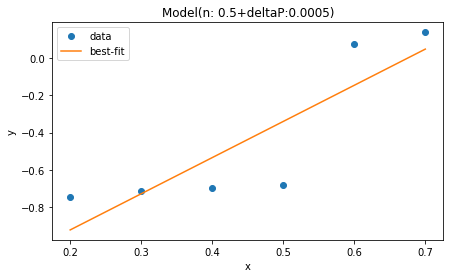

log(NuMean) =1.5402001243775822* Nu0  +-1.0563531934901962


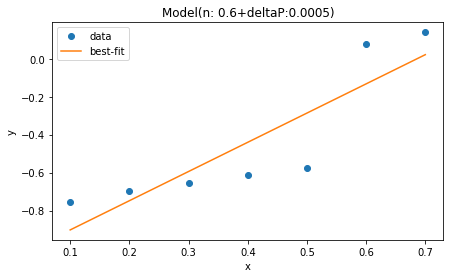

log(NuMean) =1.4588373449766368* Nu0  +-0.9462067924310262


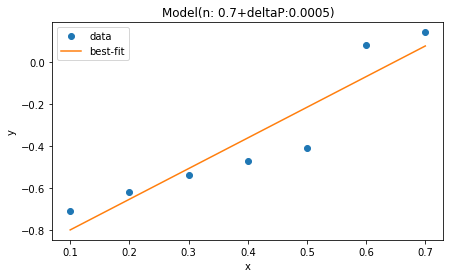

log(NuMean) =1.332106297695803* Nu0  +-0.8083406435341269


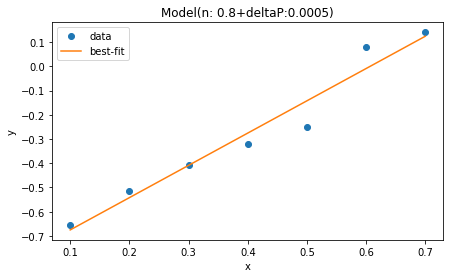

log(NuMean) =1.1854095669735256* Nu0  +-0.6667819898608762


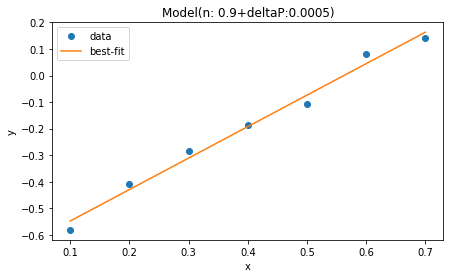

log(NuMean) =1.041445764793749* Nu0  +-0.5351925245667004


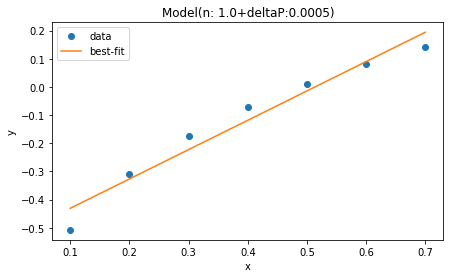

log(NuMean) =2.406203901468271* Nu0  +-1.5689345096515763


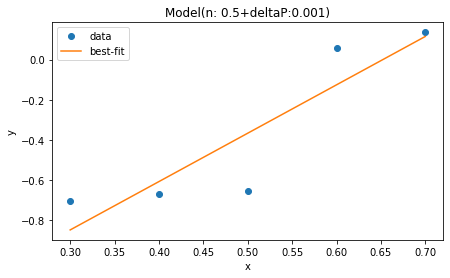

log(NuMean) =1.7740378086789048* Nu0  +-1.1769596257240547


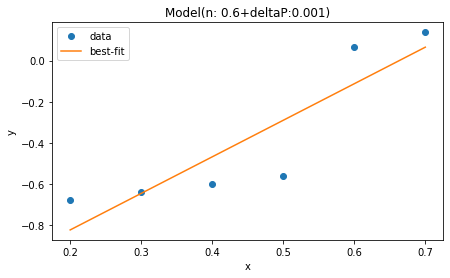

log(NuMean) =1.427895466720244* Nu0  +-0.9304279819658616


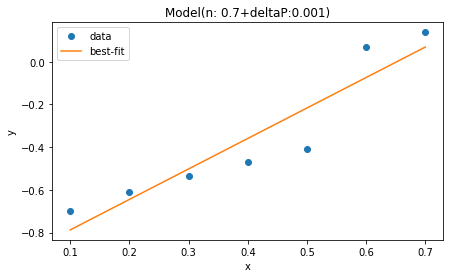

log(NuMean) =1.3177399274696708* Nu0  +-0.8021036264086555


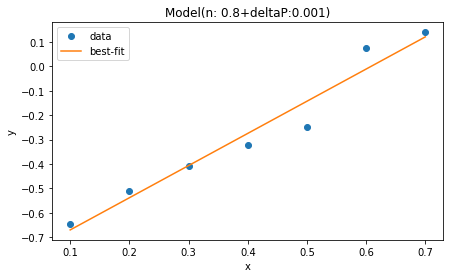

log(NuMean) =1.1809479724846927* Nu0  +-0.6652123939696962


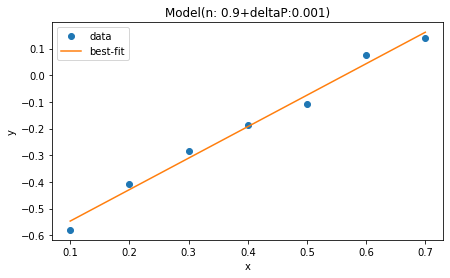

log(NuMean) =1.041445764793749* Nu0  +-0.5351925245667004


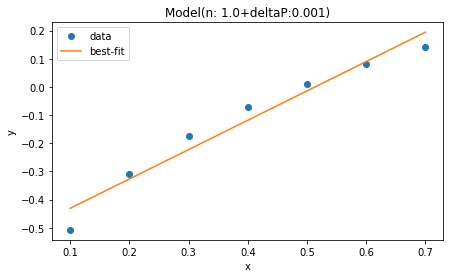

log(NuMean) =0.9358277065174126* Nu0  +-0.690244858119428


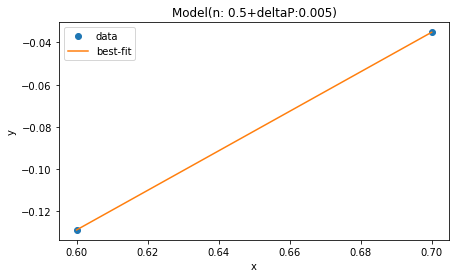

log(NuMean) =1.672165595864548* Nu0  +-1.1697473597190702


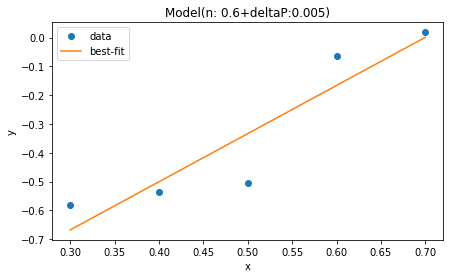

log(NuMean) =1.3289143057383968* Nu0  +-0.9068611208939608


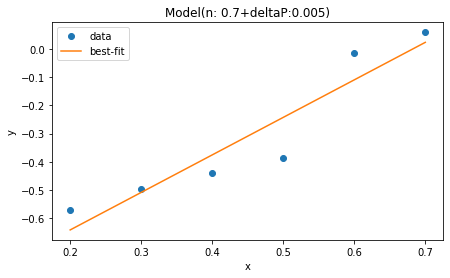

log(NuMean) =1.2046595499027903* Nu0  +-0.7638078059051715


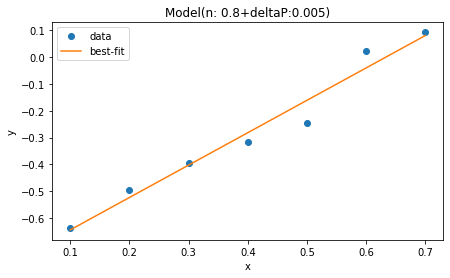

log(NuMean) =1.132718268038916* Nu0  +-0.6506549047207114


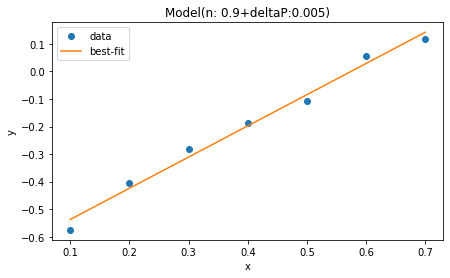

log(NuMean) =1.041445764793749* Nu0  +-0.5351925245667004


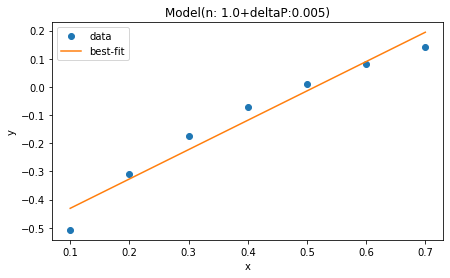

In [ ]:
Nu0_AvgNu_logarithmic=pairWise_Nu0_AvgNu_logarithmic(Berea_4)

Text(69.0, 0.5, 'deltaP')

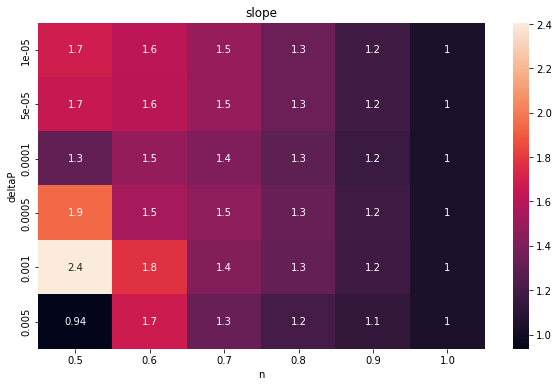

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(Nu0_AvgNu_logarithmic.slope,xticklabels=list(map(lambda i:str(i),Nu0_AvgNu_logarithmic.n_counts)), yticklabels=list(map(lambda i:str(i),Nu0_AvgNu_logarithmic.deltaP_counts)),annot=True)
p.set_xlabel("n")
p.set_ylabel("deltaP")

### coculsion for change average viscosity with Nu0

1-It seems that the when we increase the non-Newtonian behavior of the fluid (deviation from 1 for power-law exponent) the dependacy of average viscosity with pressure difference becomes more significant. The reason forthis phenomenon is the th calculated shear-rate depends on velocity and the velocity in this example was calculated based n pressure difference.

2-There is no abvious trend for deltaP 

## Dependancy of final average viscosity on n

After Pressure difference; it is time to check the depandancy of our output (AvgNu) on presssure difference for different n and Nu0 values.

In [ ]:
from lmfit.models import LinearModel

class pairWise_n_AvgNu_logarithmic:
    def __init__(self, df):
        self.df =df
        
        self.Nu0_counts=df["Nu0"].unique()
        self.deltaP_counts=df["deltaP"].unique()
        
        i=0
        j=0
        
        self.bias=np.zeros((len(self.deltaP_counts),len(self.Nu0_counts)))
        self.slope=np.zeros((len(self.deltaP_counts),len(self.Nu0_counts)))
        
        
        while i< len(self.deltaP_counts):
            self.datas=df.drop(df[df.deltaP!=self.deltaP_counts[i]].index )
            j=0
            while j< len(self.Nu0_counts):
                self.new_data=self.datas.drop(self.datas[self.datas.Nu0!=self.Nu0_counts[j]].index)
                
                plt.figure(figsize=(7,4))
                self.name="Nu0: "+str(self.Nu0_counts[j])+"+"+ "deltaP:"+str(self.deltaP_counts[i])
                #plt.title(name)
                
                model = LinearModel(name=self.name)
                params = model.guess(np.log10(self.new_data["AvgNu"]), x=self.new_data["n"])
                result = model.fit(np.log10(self.new_data["AvgNu"]), params, x=self.new_data["n"])
                self.eq="log(Nu0) = " + str(result.values["slope"])+"* n  +" + str(result.values["intercept"])
                print(self.eq)
                
                self.slope[i,j]=result.values["slope"]
                self.bias[i,j]=result.values["intercept"]
                
                result.plot_fit()
                plt.show()

                j=j+1
                
            i=i+1
            

In [ ]:
from lmfit.models import LinearModel

class pairWise_n_AvgNu_linear:
    def __init__(self, df):
        self.df =df
        
        self.Nu0_counts=df["Nu0"].unique()
        self.deltaP_counts=df["deltaP"].unique()
        
        i=0
        j=0
        
        self.bias=np.zeros((len(self.deltaP_counts),len(self.Nu0_counts)))
        self.slope=np.zeros((len(self.deltaP_counts),len(self.Nu0_counts)))
        
        
        while i< len(self.deltaP_counts):
            self.datas=df.drop(df[df.deltaP!=self.deltaP_counts[i]].index )
            j=0
            while j< len(self.Nu0_counts):
                self.new_data=self.datas.drop(self.datas[self.datas.Nu0!=self.Nu0_counts[j]].index)
                
                plt.figure(figsize=(7,4))
                self.name="Nu0: "+str(self.Nu0_counts[j])+"+"+ "deltaP:"+str(self.deltaP_counts[i])
                #plt.title(name)
                
                model = LinearModel(name=self.name)
                params = model.guess(self.new_data["AvgNu"], x=self.new_data["n"])
                result = model.fit(self.new_data["AvgNu"], params, x=self.new_data["n"])
                self.eq="AvgNu = "+ str(result.values["slope"])+"* n  +" + str(result.values["intercept"])
                print(self.eq)
                
                self.slope[i,j]=result.values["slope"]
                self.bias[i,j]=result.values["intercept"]
                
                result.plot_fit()
                plt.show()

                j=j+1
                
            i=i+1
            

NuMean = 0.33185714285714274* n  +-0.03556285714285705


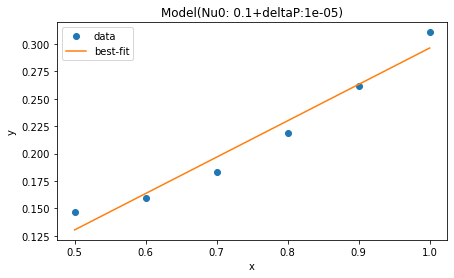

NuMean = 0.6742171428571426* n  +-0.21240619047619017


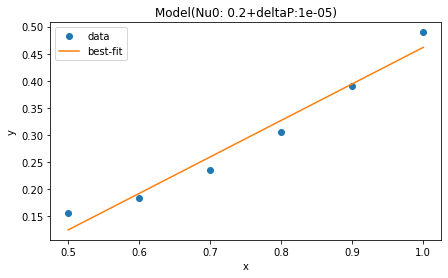

NuMean = 1.0165114285714283* n  +-0.3892219047619043


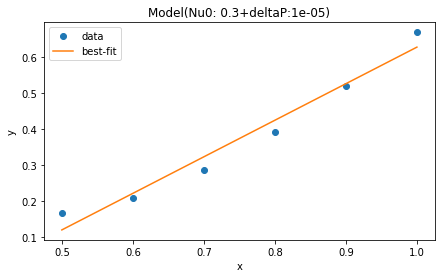

NuMean = 1.3584399999999992* n  +-0.5657266666666659


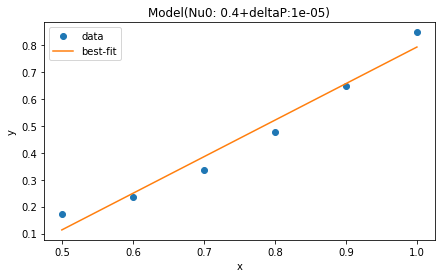

NuMean = 1.700105714285714* n  +-0.742014285714285


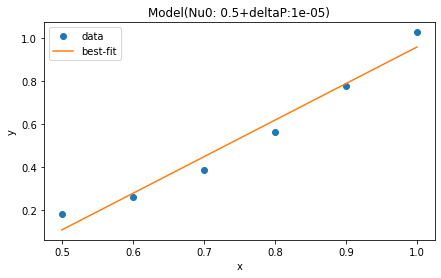

NuMean = 0.03765714285714315* n  +1.1680904761904758


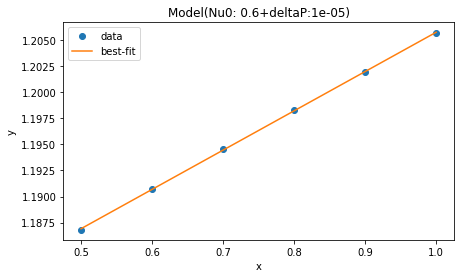

NuMean = 0.00020000000000036108* n  +1.3843666666666663


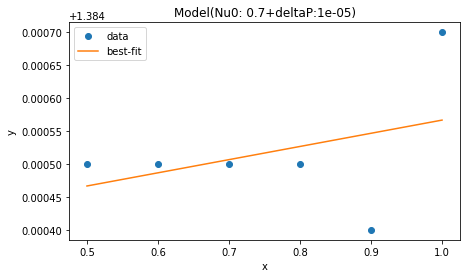

NuMean = 0.31956857142857126* n  +-0.024654761904761766


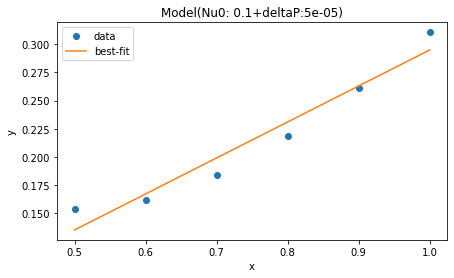

NuMean = 0.6671114285714282* n  +-0.2061719047619044


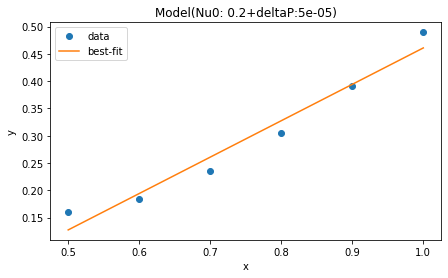

NuMean = 1.011702857142857* n  +-0.38502380952380916


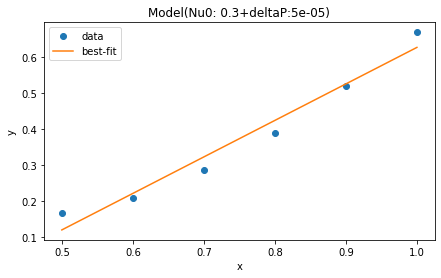

NuMean = 1.355194285714285* n  +-0.562899047619047


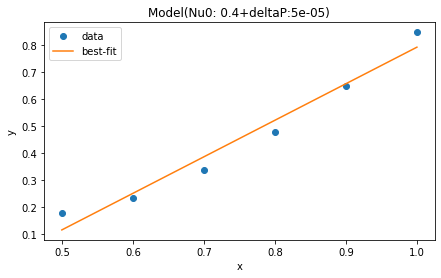

NuMean = 1.697951428571428* n  +-0.7401385714285704


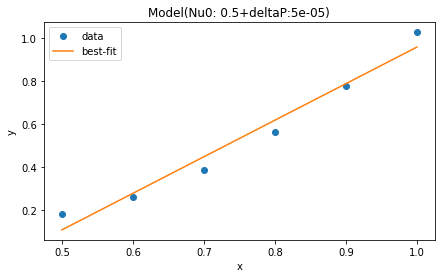

NuMean = 0.03628571428571498* n  +1.1694857142857134


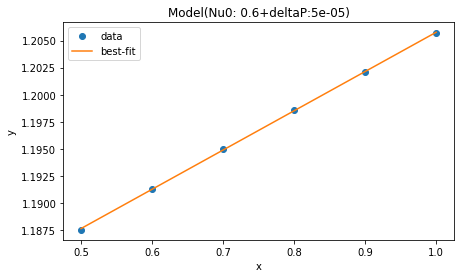

NuMean = 0.0004857142857145743* n  +1.3840523809523806


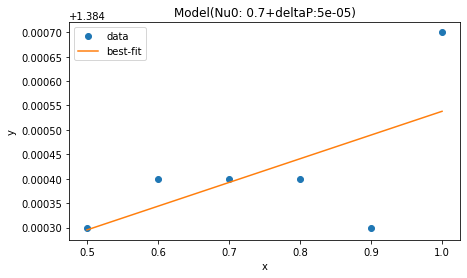

NuMean = 0.31027714285714275* n  +-0.01616619047619032


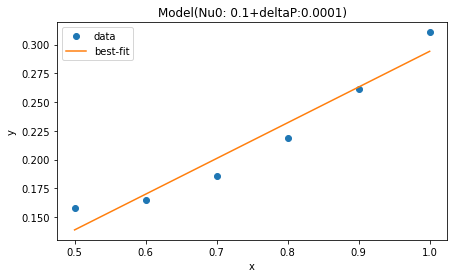

NuMean = 0.6574857142857141* n  +-0.19765761904761886


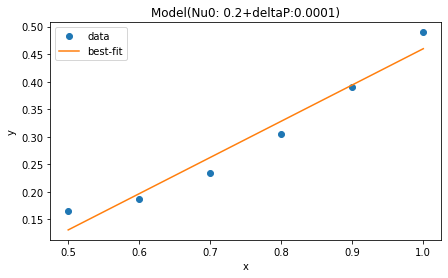

NuMean = 1.004451428571428* n  +-0.3786619047619043


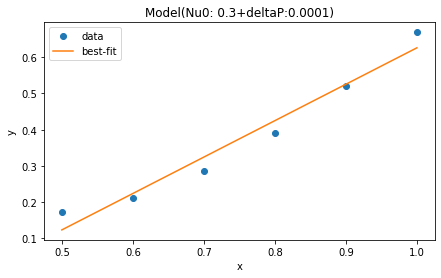

NuMean = 1.349348571428571* n  +-0.5577980952380944


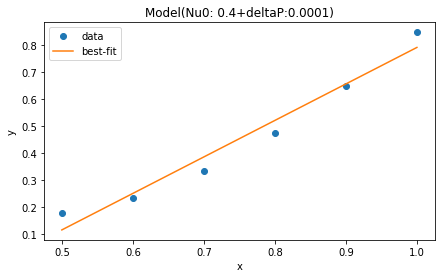

NuMean = 1.6932542857142852* n  +-0.7360490476190468


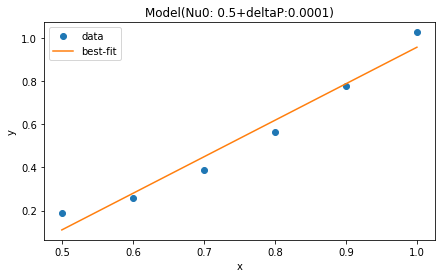

NuMean = 0.03265714285714326* n  +1.1730571428571421


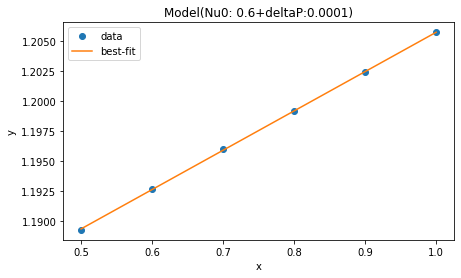

NuMean = 0.7378999999999999* n  +0.6552800000000001


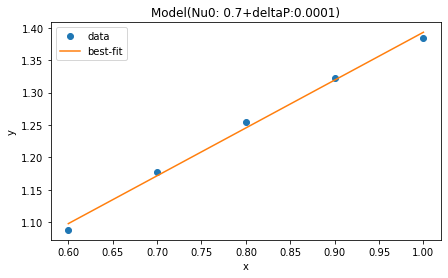

NuMean = 0.33738999999999997* n  +-0.037026000000000045


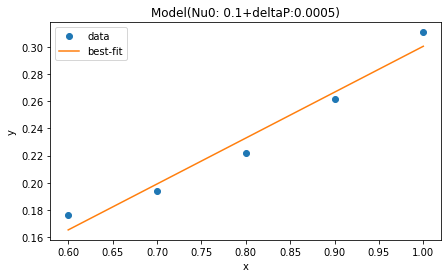

NuMean = 0.625542857142857* n  +-0.16825380952380933


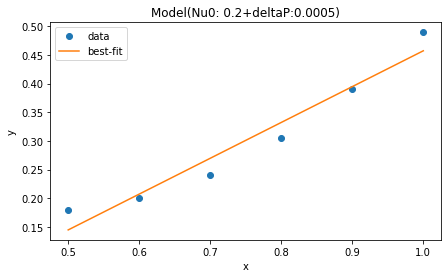

NuMean = 0.9643514285714282* n  +-0.3428452380952375


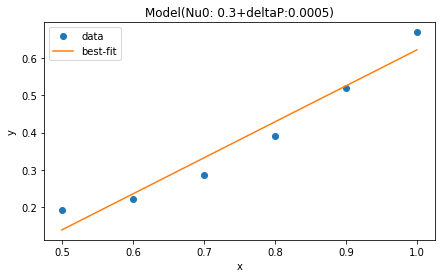

NuMean = 1.312271428571428* n  +-0.5249785714285707


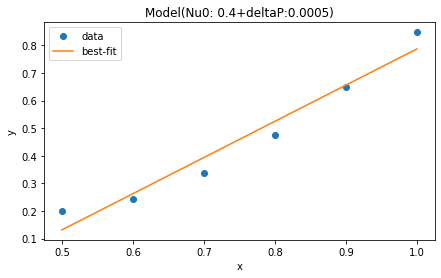

NuMean = 1.6605657142857138* n  +-0.7072742857142851


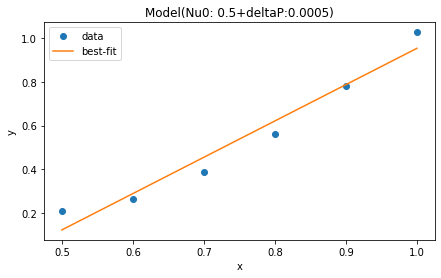

NuMean = 0.03128571428571454* n  +1.1744190476190473


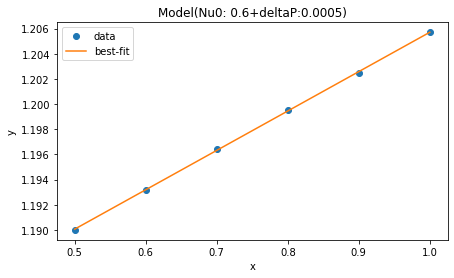

NuMean = 0.010257142857143398* n  +1.3742904761904757


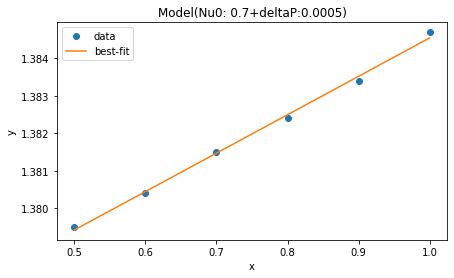

NuMean = 0.37157999999999985* n  +-0.06631799999999971


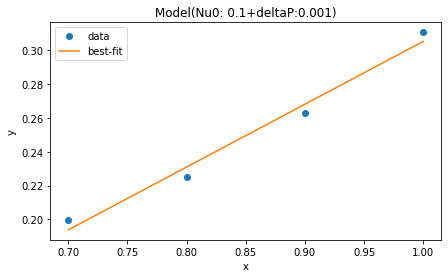

NuMean = 0.7039599999999996* n  +-0.23428599999999974


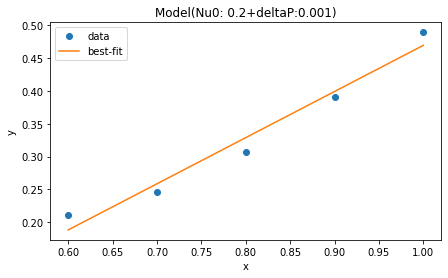

NuMean = 0.9475485714285711* n  +-0.32686809523809474


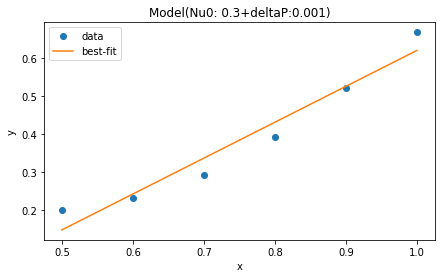

NuMean = 1.2856999999999992* n  +-0.5009066666666658


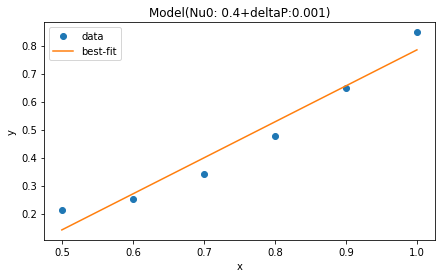

NuMean = 1.6317799999999996* n  +-0.6815299999999992


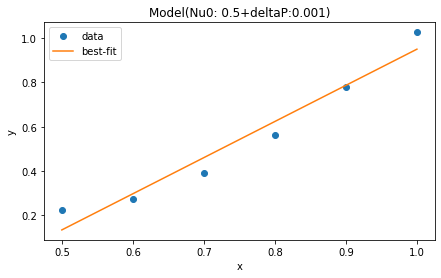

NuMean = 0.11611428571428649* n  +1.090447619047618


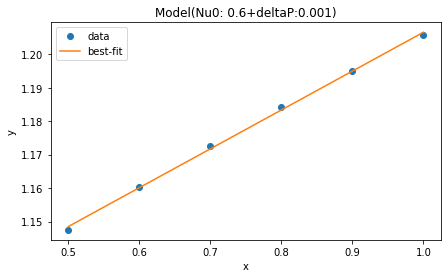

NuMean = 0.031171428571429575* n  +1.3534047619047611


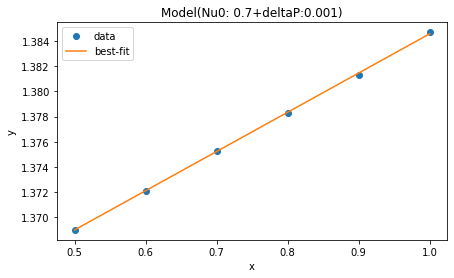

NuMean = 0.40270000000000006* n  +-0.09350333333333359


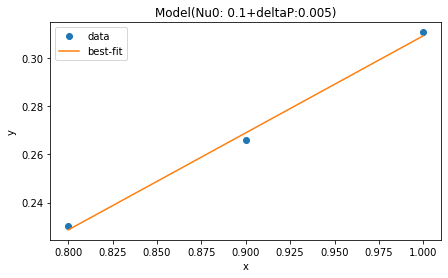

NuMean = 0.7387199999999996* n  +-0.25970699999999947


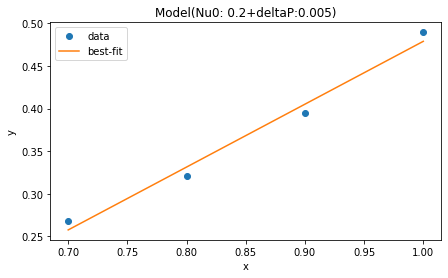

NuMean = 1.0180599999999995* n  +-0.3798179999999996


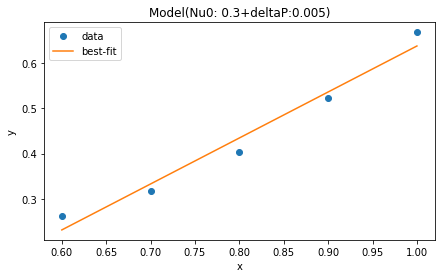

NuMean = 1.4007399999999994* n  +-0.5931479999999997


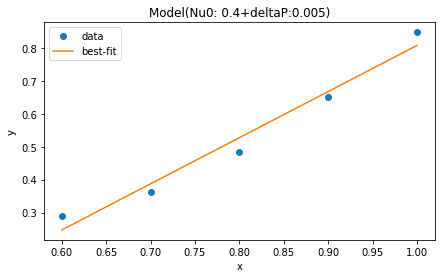

NuMean = 1.7959599999999993* n  +-0.8173959999999996


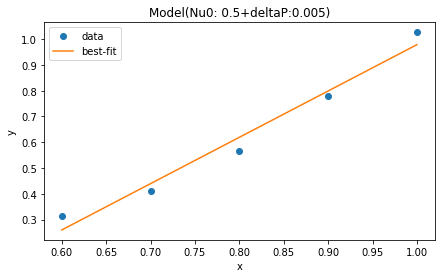

NuMean = 0.9197599999999997* n  +0.3040333333333337


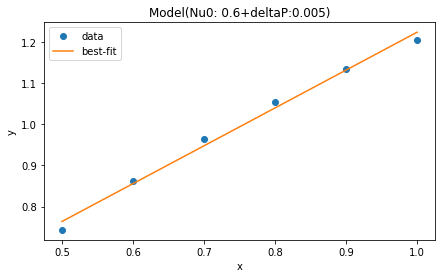

NuMean = 0.9179142857142863* n  +0.4856676190476185


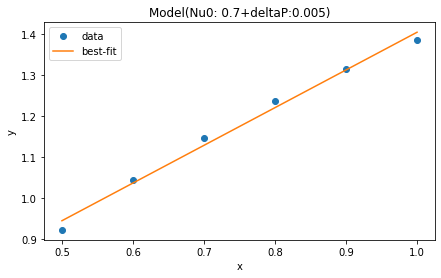

In [ ]:
n_AvgNu_linear=pairWise_n_AvgNu_linear(Berea_4)

Text(69.0, 0.5, 'deltaP')

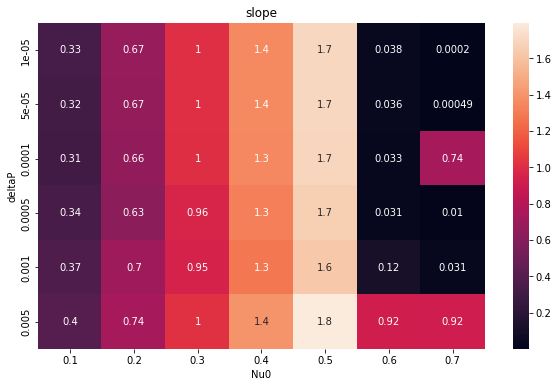

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(n_AvgNu_linear.slope,xticklabels=list(map(lambda i:str(i),n_AvgNu_linear.Nu0_counts)), yticklabels=list(map(lambda i:str(i),n_AvgNu_linear.deltaP_counts)),annot=True)
p.set_xlabel("Nu0")
p.set_ylabel("deltaP")

log(Nu0) = 0.6719198649980027* n  +-1.1904221081422504


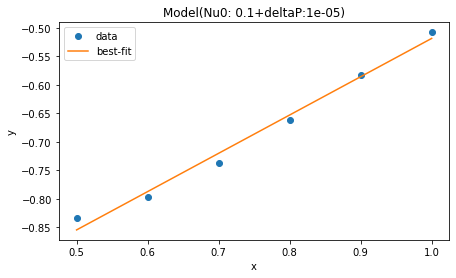

log(Nu0) = 1.023186032508675* n  +-1.3351508301500785


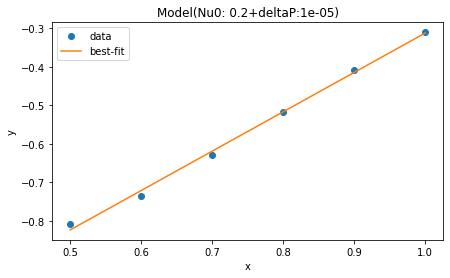

log(Nu0) = 1.2470566098501876* n  +-1.4142643253696643


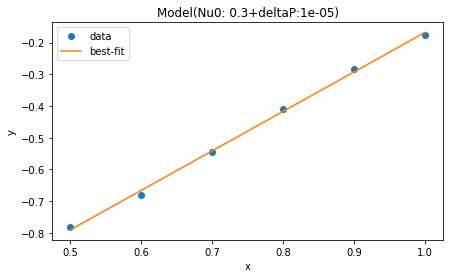

log(Nu0) = 1.4053994734473665* n  +-1.4613476373153937


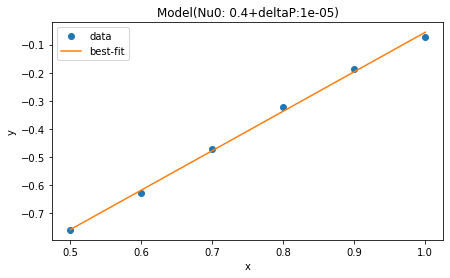

log(Nu0) = 1.5247195402901388* n  +-1.4904565102662846


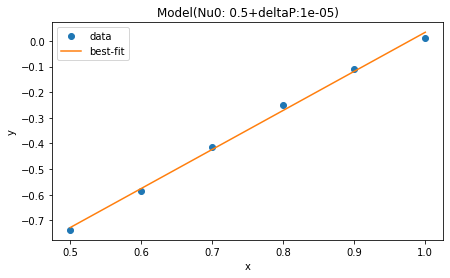

log(Nu0) = 0.013671317110163303* n  +0.0675924383484894


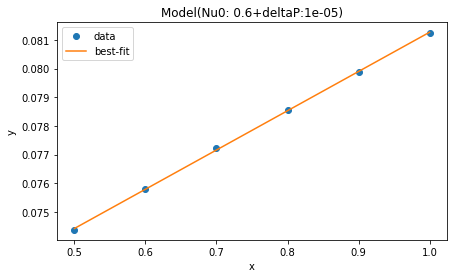

log(Nu0) = 6.272920942083002e-05* n  +0.1412511402849932


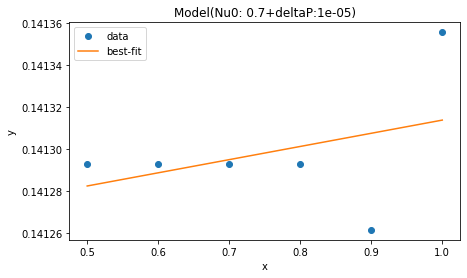

log(Nu0) = 0.6368075889386442* n  +-1.1593316079589002


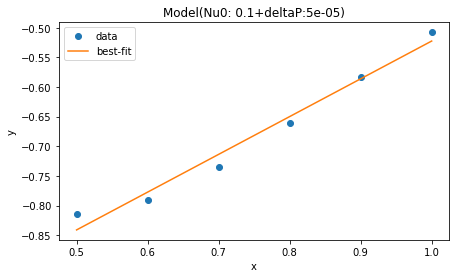

log(Nu0) = 1.0039722335735874* n  +-1.318330401875175


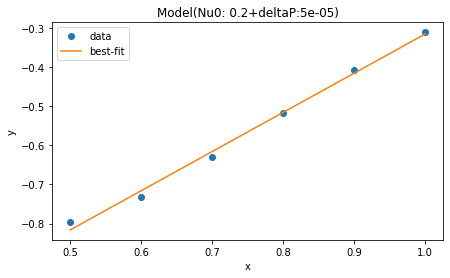

log(Nu0) = 1.2346585806592498* n  +-1.4034619946177311


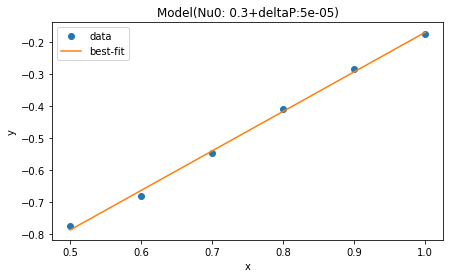

log(Nu0) = 1.3974548161844766* n  +-1.454435854113468


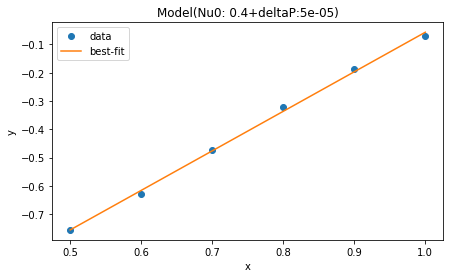

log(Nu0) = 1.5196982293411205* n  +-1.4860909549557941


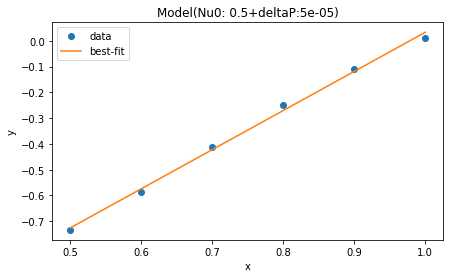

log(Nu0) = 0.013169413501921617* n  +0.06810240600508072


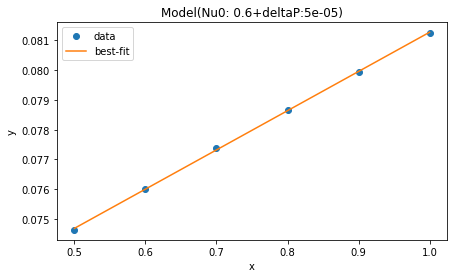

log(Nu0) = 0.00015235753143366088* n  +0.1411525488286449


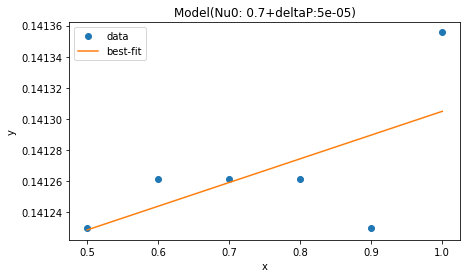

log(Nu0) = 0.6113443185288052* n  +-1.136193573140059


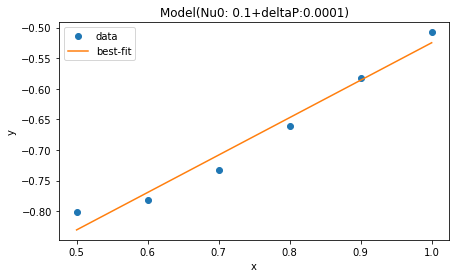

log(Nu0) = 0.9789337939912853* n  +-1.2962497246170468


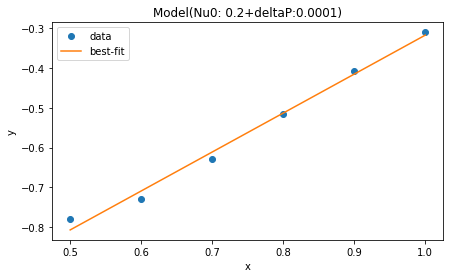

log(Nu0) = 1.2165715504836783* n  +-1.3876350829075066


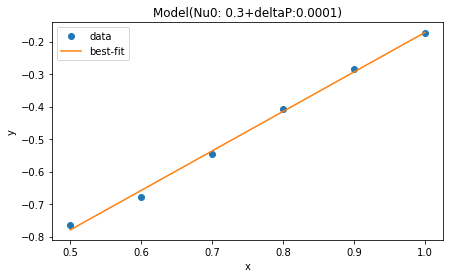

log(Nu0) = 1.3834055611087346* n  +-1.4422005728991034


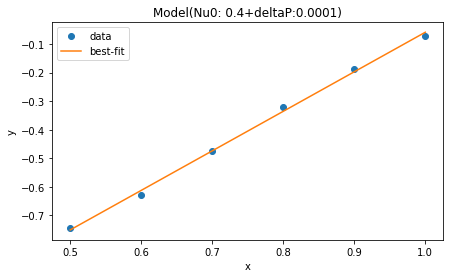

log(Nu0) = 1.508879816278906* n  +-1.4766852814561684


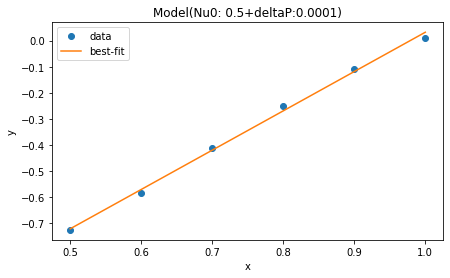

log(Nu0) = 0.01184368437283559* n  +0.06940618107375306


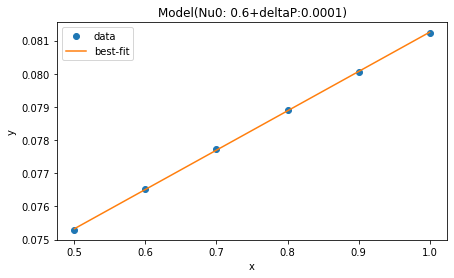

log(Nu0) = 0.2596776826159364* n  +-0.11392147211107664


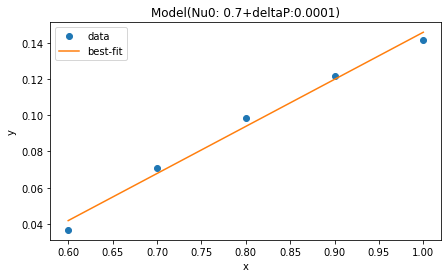

log(Nu0) = 0.6241886085896928* n  +-1.141394271446642


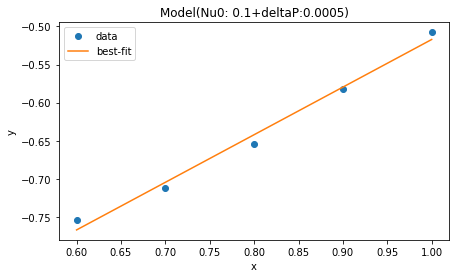

log(Nu0) = 0.9022053575774275* n  +-1.2263206726717446


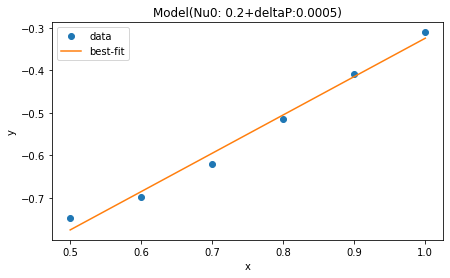

log(Nu0) = 1.1250555411897063* n  +-1.3063815463102384


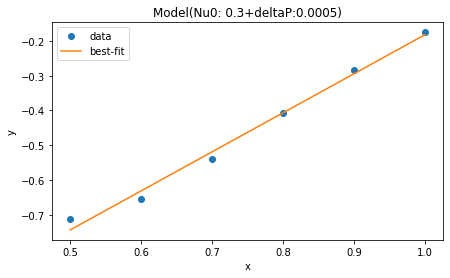

log(Nu0) = 1.302091257683313* n  +-1.370580716559078


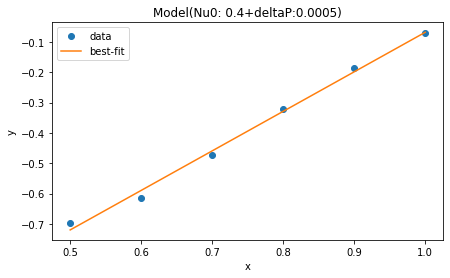

log(Nu0) = 1.4395511780777617* n  +-1.4159201908221781


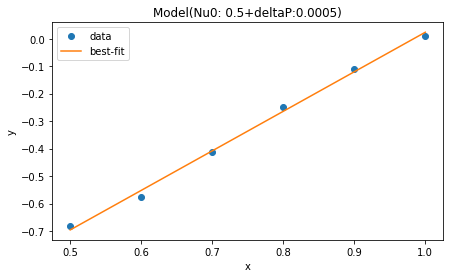

log(Nu0) = 0.011343104745124179* n  +0.0699028728916989


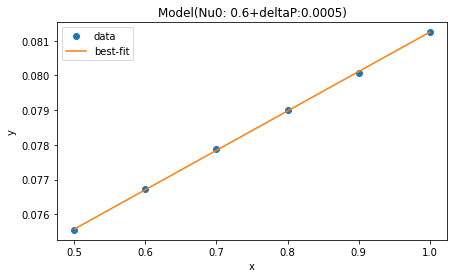

log(Nu0) = 0.0032232099986727594* n  +0.138085048062421


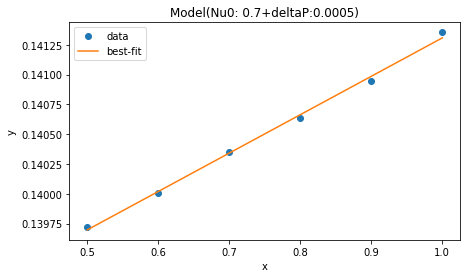

log(Nu0) = 0.6451001955472645* n  +-1.1572729204663177


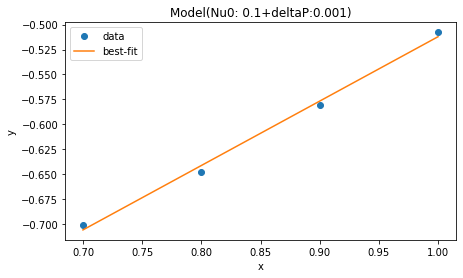

log(Nu0) = 0.9355561775241494* n  +-1.2517360730037232


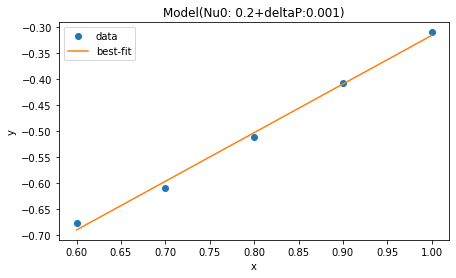

log(Nu0) = 1.0909346587545186* n  +-1.2744813946851385


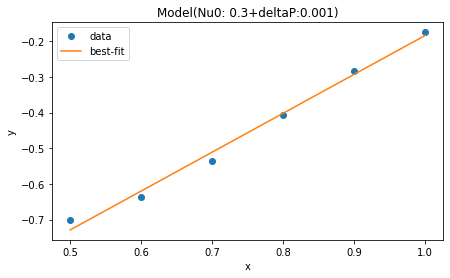

log(Nu0) = 1.2495672793578665* n  +-1.32345891051535


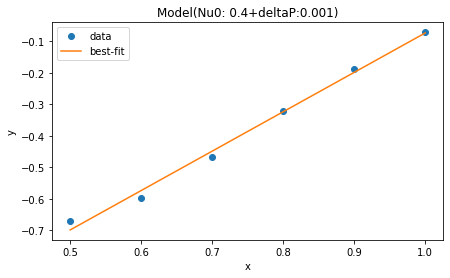

log(Nu0) = 1.3845160479288732* n  +-1.3670779914140567


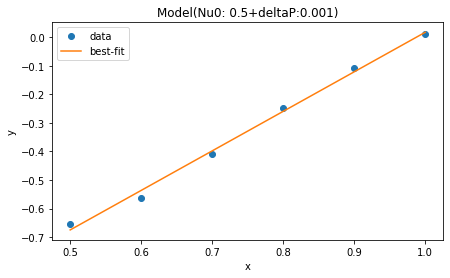

log(Nu0) = 0.042853976771611166* n  +0.038770986260971245


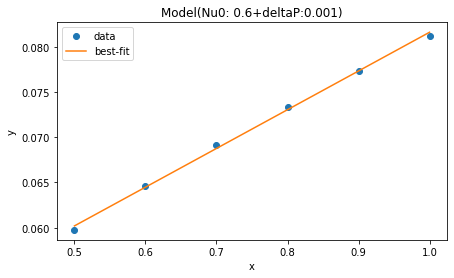

log(Nu0) = 0.009832650270005195* n  +0.1314878649019357


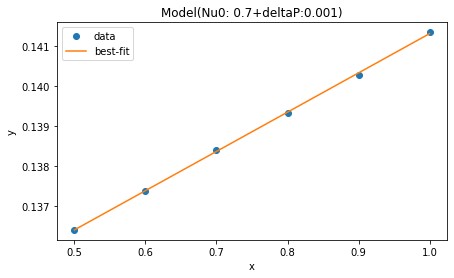

log(Nu0) = 0.6516303997784875* n  +-1.1600935142773068


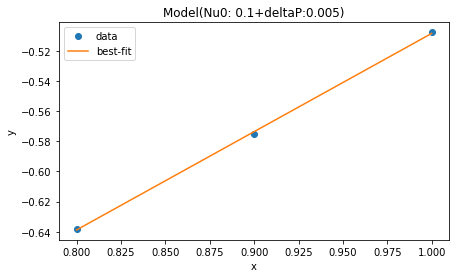

log(Nu0) = 0.874952173755082* n  +-1.1886751804425308


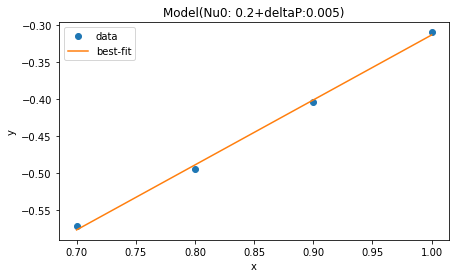

log(Nu0) = 1.0299541751982308* n  +-1.210331264269961


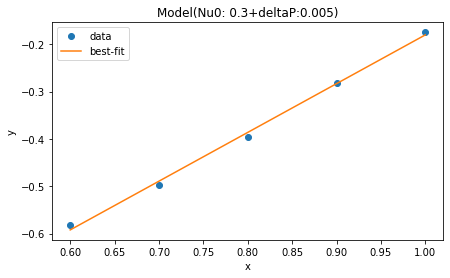

log(Nu0) = 1.1819593208870727* n  +-1.2553474911240947


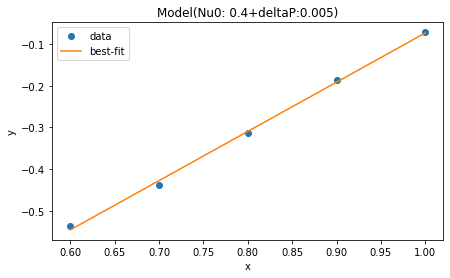

log(Nu0) = 1.3094677863202437* n  +-1.2943818123196673


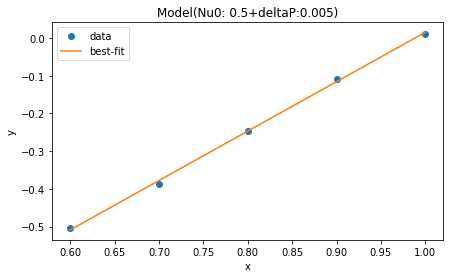

log(Nu0) = 0.4134200214832917* n  +-0.3184867397310636


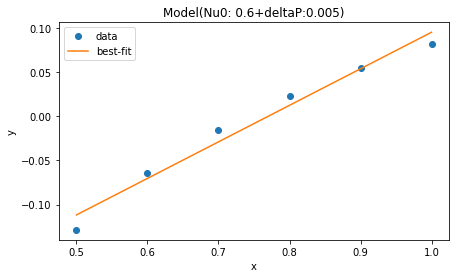

log(Nu0) = 0.3472607717536265* n  +-0.19480647484326255


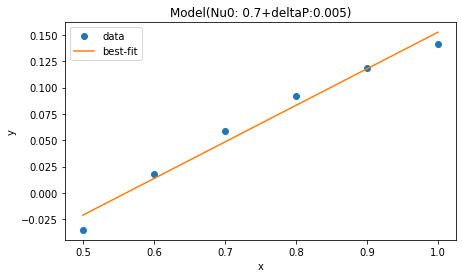

In [ ]:
n_AvgNu_logarithmic=pairWise_n_AvgNu_logarithmic(Berea_4)

Text(69.0, 0.5, 'deltaP')

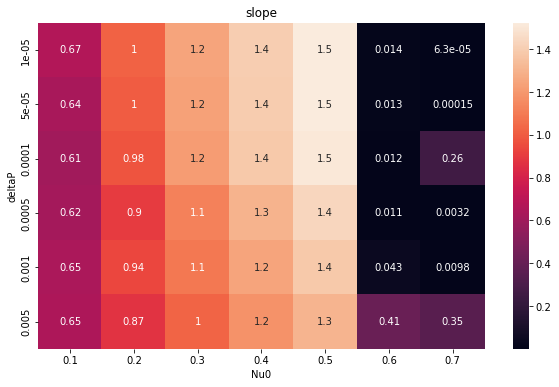

In [ ]:
plt.figure(figsize=(10,6))
plt.title('slope')


p=sns.heatmap(n_AvgNu_logarithmic.slope,xticklabels=list(map(lambda i:str(i),n_AvgNu_logarithmic.Nu0_counts)), yticklabels=list(map(lambda i:str(i),n_AvgNu_logarithmic.deltaP_counts)),annot=True)
p.set_xlabel("Nu0")
p.set_ylabel("deltaP")

### coculsion for change average viscosity with n

1-It seems there is a good linear relationship between n and AvgNu. It make sense for logarithmic scale ( log(AvgNu) ∝ n) But in the other case it should be analyzed more carefully.